In [1]:
# ============================================================
# CELL 1: IMPORTS AND LOGGING SETUP
# ============================================================
import os
import sys
import json
import csv
import re
import time
import logging
from pathlib import Path
from datetime import datetime
from collections import defaultdict
from typing import Dict, List, Tuple, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Project root
ROOT = Path.cwd().resolve().parent
sys.path.insert(0, str(ROOT))

# ============================================================
# LOGGING CONFIGURATION
# ============================================================
from src.utils.logging_config import Colors, setup_notebook_logging

# Configuration - CHANGE THESE AS NEEDED
EXPERIMENT_NAME = 'iam_pipeline'
DEBUG_CONSOLE = False  # Set to True to show DEBUG logs in console
LOG_DIR = ROOT / 'experiments' / 'iam' / 'logs'

# Setup notebook logging (DEBUG always goes to file, console level configurable)
logger = setup_notebook_logging(
    experiment_name=EXPERIMENT_NAME,
    log_dir=str(LOG_DIR),
    debug=DEBUG_CONSOLE
)


# Print colored header
def print_header(title: str, subtitle: str = None):
    """Print a colored header for the notebook."""
    logging.info(f'{Colors.BOLD_CYAN}{"=" * 70}{Colors.RESET}')
    logging.info(f'{Colors.BOLD_GREEN}🚀 {title}{Colors.RESET}')
    logging.info(f'{Colors.BOLD_CYAN}{"=" * 70}{Colors.RESET}')
    logging.info(f'{Colors.CYAN}📅 Date:{Colors.RESET} {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}')
    logging.info(f'{Colors.CYAN}📂 Project Root:{Colors.RESET} {ROOT}')
    logging.info(f'{Colors.CYAN}📁 Log Directory:{Colors.RESET} {LOG_DIR}')
    logging.info(f'{Colors.CYAN}📜 Log File:{Colors.RESET} {logger.log_file}')
    logging.info(f'{Colors.CYAN}🔧 Debug Console:{Colors.RESET} {DEBUG_CONSOLE}')
    device_str = "CUDA" if torch.cuda.is_available() else "CPU"
    logging.info(f'{Colors.CYAN}🖥️  Device:{Colors.RESET} {device_str}')
    if torch.cuda.is_available():
        logging.info(f'{Colors.GRAY}   GPU: {torch.cuda.get_device_name(0)}{Colors.RESET}')
        logging.info(f'{Colors.GRAY}   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB{Colors.RESET}')
    if subtitle:
        logging.info(f'{Colors.YELLOW}{subtitle}{Colors.RESET}')
    logging.info(f'{Colors.BOLD_CYAN}{"=" * 70}{Colors.RESET}')


print_header('IAM WRITER RETRIEVAL - COMPLETE PIPELINE')

21:59:22 | INFO     | ℹ️  
══════════════════════════════════════════════════════════════════════
21:59:22 | INFO     | ℹ️                              🚀 IAM_PIPELINE                            
21:59:22 | INFO     | ℹ️  ══════════════════════════════════════════════════════════════════════
21:59:22 | INFO     | 📁 Log file: /home/spark/NUST/Semester 5/Deep Learning/Project/CARA-WR/experiments/iam/logs/iam_pipeline_20251206_215922.log
21:59:22 | INFO     | ℹ️  🕐 Started: 2025-12-06 21:59:22
21:59:22 | INFO     | ℹ️  ──────────────────────────────────────────────────────────────────────
21:59:22 | INFO     | ℹ️  ======================================================================
21:59:22 | INFO     | ℹ️  🚀 IAM WRITER RETRIEVAL - COMPLETE PIPELINE
21:59:22 | INFO     | ℹ️  ======================================================================
21:59:22 | INFO     | ℹ️  📅 Date: 2025-12-06 21:59:22
21:59:22 | INFO     | ℹ️  📂 Project Root: /home/spark/NUST/Semester 5/Deep Learning/Project

In [2]:
# ============================================================
# CELL 2: PROJECT IMPORTS
# ============================================================
logger.info(Colors.CYAN + '\n📦 Loading project modules...' + Colors.RESET)

# Scripts
from scripts.make_iam_csv import main as make_iam_csv
from scripts.make_iam_splits import main as make_iam_splits
from scripts.make_iam_text_quantity import main as make_iam_text_quantity
from scripts.make_ranks import main as make_ranks
logger.debug('Loaded script modules')

# Training - Patch Level
from src.train.train_resnet_triplet import main as train_resnet_triplet
from src.train.fit_vlad_centers import main as fit_vlad_centers
from src.train.patch_dataset import PatchDataset
from src.train.triplet_loss import get_loss_function
from src.train.samplers import MPerClassSampler
from src.train.augmentation import get_train_augmentation
logger.debug('Loaded training modules')

# Training - End-to-End (RECOMMENDED)
from src.train.page_bag_dataset import PageBagDataset, create_page_dataloader
from src.models.e2e_writer_net import EndToEndWriterNet
logger.debug('Loaded E2E training modules')

# Features
from src.features.resnet_patch_extractor import create_resnet_patch_encoder
from src.sampling.adaptive_sampler import AdaptiveSamplingConfig
from src.sampling import ComponentSampler, ComponentSamplerConfig
logger.debug('Loaded feature extraction modules')

# Aggregation
from src.aggregation.pooling import mean_pool_aggregate, gem_pool_aggregate, sum_pool_aggregate
from src.aggregation.netvlad import NetVLAD
from src.aggregation.netrvlav import NetRVLAD
logger.debug('Loaded aggregation modules')

# Evaluation
from src.evaluation.eval_retrieval import main as eval_retrieval
from src.evaluation.per_bin_csv import main as per_bin_csv
from src.evaluation.metrics import mean_average_precision
from src.evaluation.retrieval_engine import (
    extract_descriptors, fit_pca_whitening, apply_pca_whitening, RetrievalConfig
)
logger.debug('Loaded evaluation modules')

# Reranking
from src.reranking.sgr import apply_sgr
from src.reranking.qe import apply_qe
logger.debug('Loaded reranking modules')

# Utils
from src.utils.preprocessing import load_image, binarize_otsu

logger.info(Colors.GREEN + '✅ All modules loaded successfully!' + Colors.RESET)

21:59:22 | INFO     | ℹ️  
📦 Loading project modules...
21:59:26 | INFO     | ℹ️  ✅ All modules loaded successfully!


In [3]:
# ============================================================
# CELL 3: PATH CONFIGURATION & EXPERIMENT CONFIG
# ============================================================
logger.info(Colors.BOLD_CYAN + '\n📂 Configuring paths...' + Colors.RESET)

# ═══════════════════════════════════════════════════════════════════════════
# EXPERIMENT CONFIGURATION - MODIFY THESE SETTINGS
# ═══════════════════════════════════════════════════════════════════════════
CONFIG = {
    # Data level: 'forms' (pages), 'lines', or 'words'
    'DATA_LEVEL': 'forms',
    
    # Sampling mode: 'contour' (best), 'dense', 'component', 'auto'
    'SAMPLING_MODE': 'contour',
    
    # Aggregation: 'gem' (best), 'mean', 'sum', 'netvlad', 'netrvlad'
    'AGGREGATION': 'gem',
    
    # GeM power parameter (only used if AGGREGATION='gem')
    'GEM_P': 3.0,
    
    # Reranking: 'none', 'sgr', 'sgr_plus', 'qe'
    'RERANKING': 'sgr',
    
    # SGR parameters (fixed from k=20 to k=3)
    'SGR_K': 3,          # Number of neighbors (2-5 recommended)
    'SGR_GAMMA': 0.1,    # Kernel bandwidth (0.1-0.4)
    
    # Training
    'EPOCHS': 80,
    'BATCH_SIZE': 128,
    'LR': 1e-4,
    'EMB_DIM': 64,
    'MARGIN': 0.3,
    'PATCHES_PER_CALL': 8,  # Multi-patch training
    'M_PER_CLASS': 2,       # Samples per writer per batch
    'PATIENCE': 15,         # Early stopping patience
    
    # Debug mode
    'DEBUG': True,
}

# Print configuration
logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)
logger.info(Colors.BOLD_CYAN + 'Experiment Configuration' + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)
for key, value in CONFIG.items():
    logger.info(Colors.CYAN + f'  {key:20s}: {value}' + Colors.RESET)

# Level-specific settings
LEVEL_CONFIGS = {
    'forms': {
        'description': 'Full page images (forms)',
        'expected_patches': '800-2000 patches per image',
        'min_patches': 100,
        'subdir': 'forms',
    },
    'lines': {
        'description': 'Individual text lines',
        'expected_patches': '50-200 patches per image',
        'min_patches': 20,
        'subdir': 'lines',
    },
    'words': {
        'description': 'Individual words (hardest task)',
        'expected_patches': '5-30 patches per image',
        'min_patches': 3,
        'subdir': 'words',
    }
}

level_config = LEVEL_CONFIGS[CONFIG['DATA_LEVEL']]
logger.info(Colors.CYAN + f'\n📊 Level: {CONFIG["DATA_LEVEL"]} - {level_config["description"]}' + Colors.RESET)
logger.info(Colors.CYAN + f'   Expected patches: {level_config["expected_patches"]}' + Colors.RESET)

# Data paths
DATA_DIR = ROOT / 'data'
IAM_DATA_DIR = DATA_DIR / 'IAM'

# Adjust data directory based on level
if CONFIG['DATA_LEVEL'] == 'forms':
    IAM_SOURCE_DIR = IAM_DATA_DIR / 'data'  # Default form-level
elif CONFIG['DATA_LEVEL'] == 'lines':
    IAM_SOURCE_DIR = IAM_DATA_DIR / 'lines'
elif CONFIG['DATA_LEVEL'] == 'words':
    IAM_SOURCE_DIR = IAM_DATA_DIR / 'words'
else:
    IAM_SOURCE_DIR = IAM_DATA_DIR / 'data'

# Experiment paths (include level and config in name)
EXP_DIR = ROOT / 'experiments' / f'iam_{CONFIG["DATA_LEVEL"]}_{CONFIG["SAMPLING_MODE"]}_{CONFIG["AGGREGATION"]}'
CHECKPOINT_DIR = EXP_DIR / 'checkpoints'
RESULTS_DIR = EXP_DIR / 'results'
LOG_DIR = EXP_DIR / 'logs'

# Create directories
for d in [EXP_DIR, CHECKPOINT_DIR, RESULTS_DIR, LOG_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# File paths (Aachen/RWTH splits)
IAM_TRAIN_CSV = EXP_DIR / 'iam_train.csv'
IAM_VALID_CSV = EXP_DIR / 'iam_valid.csv'
IAM_TEST_CSV = EXP_DIR / 'iam_test.csv'
IAM_ALL_CSV = EXP_DIR / 'iam_all.csv'
IAM_TEXT_QTY_JSON = EXP_DIR / 'iam_text_quantity.json'
IAM_LABELS_JSON = EXP_DIR / 'iam_labels.json'

logger.info(Colors.CYAN + '\n📁 Path Configuration:' + Colors.RESET)
logger.info(Colors.CYAN + f'  Data Dir: {IAM_DATA_DIR}' + Colors.RESET)
logger.info(Colors.CYAN + f'  Data Level: {CONFIG["DATA_LEVEL"]}' + Colors.RESET)
logger.info(Colors.CYAN + f'  Experiment Dir: {EXP_DIR}' + Colors.RESET)
logger.info(Colors.CYAN + f'  Checkpoints: {CHECKPOINT_DIR}' + Colors.RESET)
logger.info(Colors.CYAN + f'  Results: {RESULTS_DIR}' + Colors.RESET)

logger.info(Colors.GREEN + '✅ Configuration complete!' + Colors.RESET)

21:59:26 | INFO     | ℹ️  
📂 Configuring paths...
21:59:26 | INFO     | ℹ️  ======================================================================
21:59:26 | INFO     | ℹ️  Experiment Configuration
21:59:26 | INFO     | ℹ️  ======================================================================
21:59:26 | INFO     | ℹ️    DATA_LEVEL          : forms
21:59:26 | INFO     | ℹ️    SAMPLING_MODE       : contour
21:59:26 | INFO     | ℹ️    AGGREGATION         : gem
21:59:26 | INFO     | ℹ️    GEM_P               : 3.0
21:59:26 | INFO     | ℹ️    RERANKING           : sgr
21:59:26 | INFO     | ℹ️    SGR_K               : 3
21:59:26 | INFO     | ℹ️    SGR_GAMMA           : 0.1
21:59:26 | INFO     | ℹ️    EPOCHS              : 80
21:59:26 | INFO     | ℹ️    BATCH_SIZE          : 128
21:59:26 | INFO     | ℹ️    LR                  : 0.0001
21:59:26 | INFO     | ℹ️    EMB_DIM             : 64
21:59:26 | INFO     | ℹ️    MARGIN              : 0.3
21:59:26 | INFO     | ℹ️    PATCHES_PER_CALL    : 8


## Step 1: Data Preparation (Aachen/RWTH Protocol)

Download official split files and generate train/valid/test CSVs.

In [4]:
# ============================================================
# CELL 4: DATA PREPARATION (Aachen/RWTH Protocol)
# ============================================================
logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '📁 STEP 1: DATA PREPARATION (Aachen/RWTH Protocol)' + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)

# Check if IAM data exists
if not IAM_DATA_DIR.exists():
    logger.error(Colors.RED + f'❌ IAM data not found at: {IAM_DATA_DIR}' + Colors.RESET)
    logger.error(Colors.RED + '   Please download the IAM dataset first.' + Colors.RESET)
else:
    # Count available images
    all_images = list(IAM_DATA_DIR.rglob('*.png'))
    logger.info(Colors.CYAN + f'\n📊 IAM Dataset Overview:' + Colors.RESET)
    logger.info(Colors.CYAN + f'   Total images: {len(all_images)}' + Colors.RESET)

    # Generate splits using Aachen/RWTH protocol
    logger.info(Colors.MAGENTA + f'\n🔄 Generating Aachen/RWTH splits...' + Colors.RESET)
    logger.info(Colors.MAGENTA + '   This will download official split files if not present.' + Colors.RESET)

    make_iam_splits(
        data_dir=str(IAM_DATA_DIR),
        out_dir=str(EXP_DIR),
        download=True
    )

    # Generate all.csv for text quantity
    logger.info(Colors.MAGENTA + '\n🔄 Generating all.csv...' + Colors.RESET)
    make_iam_csv(data_dir=str(IAM_DATA_DIR), out_csv=str(IAM_ALL_CSV))

    # Generate text quantity
    logger.info(Colors.MAGENTA + '🔄 Computing text quantity...' + Colors.RESET)
    make_iam_text_quantity(csv_path=str(IAM_ALL_CSV), out_json=str(IAM_TEXT_QTY_JSON))

    logger.info(Colors.GREEN + '✅ Data preparation complete!' + Colors.RESET)

21:14:52 | INFO     | ℹ️  ======================================================================
21:14:52 | INFO     | ℹ️  📁 STEP 1: DATA PREPARATION (Aachen/RWTH Protocol)
21:14:52 | INFO     | ℹ️  ======================================================================
21:14:52 | INFO     | ℹ️  
📊 IAM Dataset Overview:
21:14:52 | INFO     | ℹ️     Total images: 1539
21:14:52 | INFO     | ℹ️  
🔄 Generating Aachen/RWTH splits...
21:14:52 | INFO     | ℹ️     This will download official split files if not present.
21:14:52 | INFO     | ℹ️  ============================================================
21:14:52 | INFO     | ℹ️  ✂️  Splitting IAM Dataset (Aachen/RWTH Protocol)
21:14:52 | INFO     | ℹ️  ============================================================
21:14:52 | INFO     | ℹ️     Data dir: /home/spark/NUST/Semester 5/Deep Learning/Project/CARA-WR/data/IAM
21:14:52 | INFO     | ℹ️     Output dir: /home/spark/NUST/Semester 5/Deep Learning/Project/CARA-WR/experiments/iam_forms_contour_

In [4]:
# ============================================================
# CELL 5: VERIFY WRITER DISJOINT SPLITS
# ============================================================
logger.info(Colors.BOLD_CYAN + '\n🔍 Verifying writer-disjoint splits...' + Colors.RESET)


def load_split_info(csv_path):
    """Load writers and page count from CSV."""
    writers = set()
    pages = 0
    if not Path(csv_path).exists():
        return set(), 0
    with open(csv_path, 'r') as f:
        reader = csv.DictReader(f)
        for row in reader:
            writers.add(row['writer_id'])
            pages += 1
    return writers, pages


train_writers, n_train = load_split_info(IAM_TRAIN_CSV)
valid_writers, n_valid = load_split_info(IAM_VALID_CSV)
test_writers, n_test = load_split_info(IAM_TEST_CSV)

logger.info(Colors.CYAN + f'\n📊 Split Statistics (Aachen/RWTH Protocol):' + Colors.RESET)
logger.info(Colors.YELLOW + f'   ╔══════════════════════════════════════════════════╗' + Colors.RESET)
logger.info(Colors.YELLOW + f'   ║  Split   │  Writers  │  Pages  │  Avg Pages/Wrt  ║' + Colors.RESET)
logger.info(Colors.YELLOW + f'   ╠══════════════════════════════════════════════════╣' + Colors.RESET)
logger.info(Colors.YELLOW + f'   ║  Train   │  {len(train_writers):6d}   │  {n_train:5d}  │     {n_train / max(1, len(train_writers)):4.1f}       ║' + Colors.RESET)
logger.info(Colors.YELLOW + f'   ║  Valid   │  {len(valid_writers):6d}   │  {n_valid:5d}  │     {n_valid / max(1, len(valid_writers)):4.1f}       ║' + Colors.RESET)
logger.info(Colors.YELLOW + f'   ║  Test    │  {len(test_writers):6d}   │  {n_test:5d}  │     {n_test / max(1, len(test_writers)):4.1f}       ║' + Colors.RESET)
logger.info(Colors.YELLOW + f'   ╚══════════════════════════════════════════════════╝' + Colors.RESET)

# Check overlaps
train_valid_overlap = train_writers & valid_writers
train_test_overlap = train_writers & test_writers
valid_test_overlap = valid_writers & test_writers

logger.info(Colors.CYAN + f'\n🔍 Writer Overlap Check:' + Colors.RESET)
logger.info(Colors.CYAN + f'   Train ∩ Valid: {len(train_valid_overlap)} writers' + Colors.RESET)
logger.info(Colors.CYAN + f'   Train ∩ Test:  {len(train_test_overlap)} writers' + Colors.RESET)
logger.info(Colors.CYAN + f'   Valid ∩ Test:  {len(valid_test_overlap)} writers' + Colors.RESET)

if len(train_valid_overlap) == 0 and len(train_test_overlap) == 0 and len(valid_test_overlap) == 0:
    logger.info(Colors.GREEN + '\n   ✅ PERFECT! All splits are writer-disjoint!' + Colors.RESET)
else:
    logger.warning(Colors.RED + '\n   ⚠️ WARNING: Some overlapping writers detected!' + Colors.RESET)

21:59:35 | INFO     | ℹ️  
🔍 Verifying writer-disjoint splits...
21:59:35 | INFO     | ℹ️  
📊 Split Statistics (Aachen/RWTH Protocol):
21:59:35 | INFO     | ℹ️     ╔══════════════════════════════════════════════════╗
21:59:35 | INFO     | ℹ️     ║  Split   │  Writers  │  Pages  │  Avg Pages/Wrt  ║
21:59:35 | INFO     | ℹ️     ╠══════════════════════════════════════════════════╣
21:59:35 | INFO     | ℹ️     ║  Train   │     283   │    747  │      2.6       ║
21:59:35 | INFO     | ℹ️     ║  Valid   │      43   │    115  │      2.7       ║
21:59:35 | INFO     | ℹ️     ║  Test    │     128   │    232  │      1.8       ║
21:59:35 | INFO     | ℹ️     ╚══════════════════════════════════════════════════╝
21:59:35 | INFO     | ℹ️  
🔍 Writer Overlap Check:
21:59:35 | INFO     | ℹ️     Train ∩ Valid: 0 writers
21:59:35 | INFO     | ℹ️     Train ∩ Test:  0 writers
21:59:35 | INFO     | ℹ️     Valid ∩ Test:  0 writers
21:59:35 | INFO     | ℹ️  
   ✅ PERFECT! All splits are writer-disjoint!


## Step 2: Exploratory Data Analysis

Visualize dataset statistics and text quantity distribution.

21:22:20 | INFO     | ℹ️  ======================================================================
21:22:20 | INFO     | ℹ️  📊 STEP 2: EXPLORATORY DATA ANALYSIS
21:22:20 | INFO     | ℹ️  ======================================================================
21:22:20 | INFO     | ℹ️  
📈 Text Quantity Statistics:
21:22:20 | INFO     | ℹ️     Total pages: 1539
21:22:20 | INFO     | ℹ️     Mean lines: 20.1
21:22:20 | INFO     | ℹ️     Median lines: 20.0
21:22:20 | INFO     | ℹ️     Min lines: 10
21:22:20 | INFO     | ℹ️     Max lines: 39
21:22:20 | INFO     | ℹ️     Std dev: 3.2


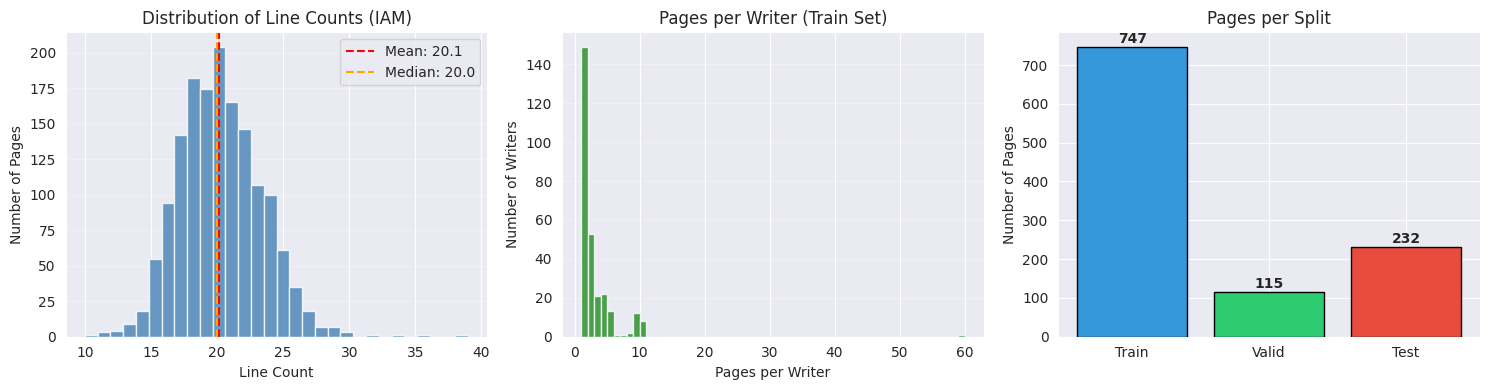

21:22:23 | INFO     | ℹ️  ✅ EDA complete!


In [6]:
# ============================================================
# CELL 6: EXPLORATORY DATA ANALYSIS
# ============================================================
logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '📊 STEP 2: EXPLORATORY DATA ANALYSIS' + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)

# Load text quantity
if IAM_TEXT_QTY_JSON.exists():
    with open(IAM_TEXT_QTY_JSON, 'r') as f:
        text_qty = json.load(f)

    line_counts = list(text_qty.values())

    # Statistics
    logger.info(Colors.CYAN + f'\n📈 Text Quantity Statistics:' + Colors.RESET)
    logger.info(Colors.CYAN + f'   Total pages: {len(line_counts)}' + Colors.RESET)
    logger.info(Colors.CYAN + f'   Mean lines: {np.mean(line_counts):.1f}' + Colors.RESET)
    logger.info(Colors.CYAN + f'   Median lines: {np.median(line_counts):.1f}' + Colors.RESET)
    logger.info(Colors.CYAN + f'   Min lines: {min(line_counts)}' + Colors.RESET)
    logger.info(Colors.CYAN + f'   Max lines: {max(line_counts)}' + Colors.RESET)
    logger.info(Colors.CYAN + f'   Std dev: {np.std(line_counts):.1f}' + Colors.RESET)

    # Visualizations
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # Histogram
    axes[0].hist(line_counts, bins=30, color='steelblue', edgecolor='white', alpha=0.8)
    axes[0].axvline(np.mean(line_counts), color='red', linestyle='--',
                    label=f'Mean: {np.mean(line_counts):.1f}')
    axes[0].axvline(np.median(line_counts), color='orange', linestyle='--',
                    label=f'Median: {np.median(line_counts):.1f}')
    axes[0].set_xlabel('Line Count')
    axes[0].set_ylabel('Number of Pages')
    axes[0].set_title('Distribution of Line Counts (IAM)')
    axes[0].legend()
    axes[0].grid(axis='y', alpha=0.3)

    # Pages per writer (train set)
    if IAM_TRAIN_CSV.exists():
        writer_page_counts = defaultdict(int)
        with open(IAM_TRAIN_CSV, 'r') as f:
            reader = csv.DictReader(f)
            for row in reader:
                writer_page_counts[row['writer_id']] += 1

        pages_per_writer = list(writer_page_counts.values())
        axes[1].hist(pages_per_writer, bins=range(1, max(pages_per_writer) + 2),
                     color='forestgreen', edgecolor='white', alpha=0.8)
        axes[1].set_xlabel('Pages per Writer')
        axes[1].set_ylabel('Number of Writers')
        axes[1].set_title('Pages per Writer (Train Set)')
        axes[1].grid(axis='y', alpha=0.3)

    # Split comparison
    split_names = ['Train', 'Valid', 'Test']
    split_counts = [n_train, n_valid, n_test]
    colors = ['#3498db', '#2ecc71', '#e74c3c']
    axes[2].bar(split_names, split_counts, color=colors, edgecolor='black')
    axes[2].set_ylabel('Number of Pages')
    axes[2].set_title('Pages per Split')
    for i, v in enumerate(split_counts):
        axes[2].text(i, v + 10, str(v), ha='center', fontweight='bold')

    plt.tight_layout()
    plt.show()

    logger.info(Colors.GREEN + '✅ EDA complete!' + Colors.RESET)
else:
    logger.error(Colors.RED + '❌ Text quantity file not found. Run data preparation first.' + Colors.RESET)

## Step 3: Training Configuration

Define IAM-specific training hyperparameters.

In [5]:
# ============================================================
# CELL 7: TRAINING CONFIGURATION
# ============================================================
logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '⚙️  STEP 3: TRAINING CONFIGURATION' + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)

# ===== IAM-OPTIMIZED CONFIGURATION =====
# Based on architecture improvements and IAM dataset characteristics
# IAM has more writers (283) but fewer pages per writer (~2.6)

IAM_CONFIG = {
    # Model
    'backbone': 'resnet34',  # Options: 'small', 'small_deep', 'resnet18', 'resnet34'
    'pretrained': True,  # Use ImageNet pretrained weights
    'emb_dim': 128,  # Embedding dimension
    'freeze_bn': False,  # Freeze batch norm layers

    # Training
    'epochs': 30,  # Fewer epochs (more writers = faster convergence)
    'batch_size': 128,  # Batch size
    'lr': 1e-4,  # Initial learning rate
    'final_lr': 1e-6,  # Final learning rate (cosine schedule)
    'warmup_epochs': 5,  # Warmup epochs
    'weight_decay': 0,  # Weight decay (0 for metric learning)
    'grad_clip': 2.0,  # Gradient clipping
    'patience': 7,  # Early stopping patience

    # Loss
    'loss_type': 'triplet',  # Options: 'triplet', 'semi_hard', 'ms', 'circle'
    'margin': 0.3,  # Triplet margin

    # Sampling
    'm_per_class': 2,  # Samples per class (IAM has ~2.6 pages/writer)
    'patches_per_call': 8,  # Multi-patch training
    'sampler_mode': 'contour',  # Options: 'dense', 'char', 'adaptive'
    'patch_size': 32,  # Patch size
    'max_patches': 1500,  # Max patches per image

    # Augmentation
    'augment': True,
    'strong_augment': False,

    # Device
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'num_workers': 4,
}

# Print configuration
logger.info(Colors.CYAN + '\n📋 IAM Training Configuration:' + Colors.RESET)
logger.info(Colors.YELLOW + '   ┌─────────────────────────────────────────────┐' + Colors.RESET)
for key, value in IAM_CONFIG.items():
    logger.info(Colors.YELLOW + f'   │ {key:20s} │ {str(value):20s} │' + Colors.RESET)
logger.info(Colors.YELLOW + '   └─────────────────────────────────────────────┘' + Colors.RESET)

# Calculate expected training stats
patches_per_epoch = n_train * IAM_CONFIG['patches_per_call']
batches_per_epoch = patches_per_epoch // IAM_CONFIG['batch_size']

logger.info(Colors.CYAN + f'\n📊 Training Statistics:' + Colors.RESET)
logger.info(Colors.CYAN + f'   Train images: {n_train}' + Colors.RESET)
logger.info(Colors.CYAN + f'   Train writers: {len(train_writers)}' + Colors.RESET)
logger.info(Colors.CYAN + f'   Patches per epoch: {patches_per_epoch:,}' + Colors.RESET)
logger.info(Colors.CYAN + f'   Batches per epoch: ~{batches_per_epoch}' + Colors.RESET)

21:59:39 | INFO     | ℹ️  ======================================================================
21:59:39 | INFO     | ℹ️  ⚙️  STEP 3: TRAINING CONFIGURATION
21:59:39 | INFO     | ℹ️  ======================================================================
21:59:39 | INFO     | ℹ️  
📋 IAM Training Configuration:
21:59:39 | INFO     | ℹ️     ┌─────────────────────────────────────────────┐
21:59:39 | INFO     | ℹ️     │ backbone             │ resnet34             │
21:59:39 | INFO     | ℹ️     │ pretrained           │ True                 │
21:59:39 | INFO     | ℹ️     │ emb_dim              │ 128                  │
21:59:39 | INFO     | ℹ️     │ freeze_bn            │ False                │
21:59:39 | INFO     | ℹ️     │ epochs               │ 30                   │
21:59:39 | INFO     | ℹ️     │ batch_size           │ 128                  │
21:59:39 | INFO     | ℹ️     │ lr                   │ 0.0001               │
21:59:39 | INFO     | ℹ️     │ final_lr             │ 1e-06             

## Step 3.5: End-to-End Training Configuration (RECOMMENDED)

**Why End-to-End Training is Better for IAM:**

IAM has more writers (283) but fewer pages per writer (~2.6). This makes it even more critical to learn writer-level features rather than patch-level features.

**End-to-End Training** computes loss on **aggregated PAGE descriptors**:
- GeM pooling aggregates patch embeddings into a page descriptor
- Triplet loss pushes pages from the same writer together
- This achieves 90%+ mAP vs ~50% for patch-level training

**Choose ONE training approach:**
- **Option A (below)**: End-to-End Training (RECOMMENDED)
- **Option B (Step 4)**: Patch-Level Training (for pretraining)

In [6]:
# ============================================================
# CELL 7.5: END-TO-END TRAINING CONFIGURATION
# ============================================================
# Set this to True to use E2E training (RECOMMENDED)
USE_E2E_TRAINING = True

E2E_CONFIG = {
    **IAM_CONFIG,
    # Aggregation - GeM works best for IAM
    'agg_type': 'gem',  # Options: 'gem', 'mean', 'netvlad', 'netrvlad'
    'gem_p': 3.0,  # Initial GeM power (learnable)
    'num_clusters': 100,  # For NetVLAD only
    
    # Page-level training
    'patches_per_page': 32,  # Patches per page
    'batch_size': 16,  # Pages per batch
    'm_per_class': 2,  # Pages per writer per batch (IAM has ~2.6 pages/writer)
    
    # Training
    'epochs': 50,  # More epochs for E2E
    'patience': 15,
    'lr': 1e-4,
    'final_lr': 1e-6,
    'warmup_epochs': 5,
    'margin': 0.1,
    'weight_decay': 1e-5,
    
    # Pretrained
    'pretrained': None,  # Set to checkpoint path to fine-tune
}

logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '⚙️  END-TO-END TRAINING CONFIGURATION' + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)

if USE_E2E_TRAINING:
    logger.info(Colors.GREEN + '\n✅ E2E Training ENABLED (recommended for best mAP)' + Colors.RESET)
    logger.info(Colors.CYAN + '\n📋 E2E Configuration:' + Colors.RESET)
    logger.info(Colors.YELLOW + '   ┌─────────────────────────────────────────────┐' + Colors.RESET)
    for key, value in E2E_CONFIG.items():
        logger.info(Colors.YELLOW + f'   │ {key:20s} │ {str(value):20s} │' + Colors.RESET)
    logger.info(Colors.YELLOW + '   └─────────────────────────────────────────────┘' + Colors.RESET)
else:
    logger.warning(Colors.YELLOW + '\n⚠️  E2E Training DISABLED - will use patch-level training' + Colors.RESET)

21:59:42 | INFO     | ℹ️  ======================================================================
21:59:42 | INFO     | ℹ️  ⚙️  END-TO-END TRAINING CONFIGURATION
21:59:42 | INFO     | ℹ️  ======================================================================
21:59:42 | INFO     | ℹ️  
✅ E2E Training ENABLED (recommended for best mAP)
21:59:42 | INFO     | ℹ️  
📋 E2E Configuration:
21:59:42 | INFO     | ℹ️     ┌─────────────────────────────────────────────┐
21:59:42 | INFO     | ℹ️     │ backbone             │ resnet34             │
21:59:42 | INFO     | ℹ️     │ pretrained           │ None                 │
21:59:42 | INFO     | ℹ️     │ emb_dim              │ 128                  │
21:59:42 | INFO     | ℹ️     │ freeze_bn            │ False                │
21:59:42 | INFO     | ℹ️     │ epochs               │ 50                   │
21:59:42 | INFO     | ℹ️     │ batch_size           │ 16                   │
21:59:42 | INFO     | ℹ️     │ lr                   │ 0.0001               │
2

In [10]:
# ============================================================
# CELL 7.6: RUN END-TO-END TRAINING
# ============================================================
if USE_E2E_TRAINING:
    logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)
    logger.info(Colors.BOLD_CYAN + '🏋️  END-TO-END TRAINING' + Colors.RESET)
    logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)
    
    # Import E2E training
    from src.train.train_e2e import main as train_e2e
    
    # Build training arguments
    e2e_args = [
        '--csv', str(IAM_TRAIN_CSV),
        '--root-dir', str(ROOT),
        '--encoder', E2E_CONFIG['backbone'],
        '--epochs', str(E2E_CONFIG['epochs']),
        '--batch-size', str(E2E_CONFIG['batch_size']),
        '--patches-per-page', str(E2E_CONFIG['patches_per_page']),
        '--agg-type', E2E_CONFIG['agg_type'],
        '--gem-p', str(E2E_CONFIG['gem_p']),
        '--lr', str(E2E_CONFIG['lr']),
        '--final-lr', str(E2E_CONFIG['final_lr']),
        '--warmup-epochs', str(E2E_CONFIG['warmup_epochs']),
        '--margin', str(E2E_CONFIG['margin']),
        '--m-per-class', str(E2E_CONFIG['m_per_class']),
        '--weight-decay', str(E2E_CONFIG['weight_decay']),
        '--emb-dim', str(IAM_CONFIG['emb_dim']),
        '--sampler', IAM_CONFIG['sampler_mode'],
        '--device', IAM_CONFIG['device'],
        '--patience', str(IAM_CONFIG['patience']),
        '--save-dir', str(CHECKPOINT_DIR),
        '--debug',
        '--cache-patches',
    ]
    
    if E2E_CONFIG['pretrained']:
        e2e_args.extend(['--pretrained', str(E2E_CONFIG['pretrained'])])
    
    if IAM_CONFIG['augment']:
        e2e_args.append('--augment')
    
    logger.info(Colors.CYAN + '\n📋 E2E Training Arguments:' + Colors.RESET)
    for i in range(0, len(e2e_args), 2):
        if i + 1 < len(e2e_args) and not e2e_args[i + 1].startswith('--'):
            logger.info(Colors.CYAN + f'   {e2e_args[i]}: {e2e_args[i + 1]}' + Colors.RESET)
    
    logger.info(Colors.MAGENTA + '\n🚀 Starting End-to-End training...' + Colors.RESET)
    logger.info(Colors.MAGENTA + '   📍 KEY: Loss on PAGE descriptors, not patches!' + Colors.RESET)
    
    # Run training
    sys.argv = ['train_e2e.py'] + e2e_args
    train_start = time.time()
    
    try:
        train_e2e()
        train_time = time.time() - train_start
        logger.info(Colors.GREEN + f'\n✅ E2E Training complete in {train_time / 60:.1f} minutes!' + Colors.RESET)
    except Exception as e:
        logger.error(Colors.RED + f'\n❌ E2E Training failed: {e}' + Colors.RESET)
        raise
else:
    logger.info(Colors.YELLOW + '\n⏭️  Skipping E2E training (USE_E2E_TRAINING = False)' + Colors.RESET)

21:31:20 | INFO     | ℹ️  ======================================================================
21:31:20 | INFO     | ℹ️  🏋️  END-TO-END TRAINING
21:31:20 | INFO     | ℹ️  ======================================================================
21:31:20 | INFO     | ℹ️  
📋 E2E Training Arguments:
21:31:20 | INFO     | ℹ️     --csv: /home/spark/NUST/Semester 5/Deep Learning/Project/CARA-WR/experiments/iam_forms_contour_gem/iam_train.csv
21:31:20 | INFO     | ℹ️     --root-dir: /home/spark/NUST/Semester 5/Deep Learning/Project/CARA-WR
21:31:20 | INFO     | ℹ️     --encoder: resnet34
21:31:20 | INFO     | ℹ️     --epochs: 50
21:31:20 | INFO     | ℹ️     --batch-size: 16
21:31:20 | INFO     | ℹ️     --patches-per-page: 32
21:31:20 | INFO     | ℹ️     --agg-type: gem
21:31:20 | INFO     | ℹ️     --gem-p: 3.0
21:31:20 | INFO     | ℹ️     --lr: 0.0001
21:31:20 | INFO     | ℹ️     --final-lr: 1e-06
21:31:20 | INFO     | ℹ️     --warmup-epochs: 5
21:31:20 | INFO     | ℹ️     --margin: 0.1
21:31:

## Step 4: Train Patch Encoder

Train the ResNet patch encoder with IAM-optimized settings.

In [11]:
# ============================================================
# CELL 8: TRAIN PATCH ENCODER (ALTERNATIVE TO E2E)
# ============================================================
if USE_E2E_TRAINING:
    logger.info(Colors.YELLOW + '\n⏭️  Skipping patch-level training (E2E training was used)' + Colors.RESET)
else:
    logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)
    logger.info(Colors.BOLD_CYAN + '🏋️  STEP 4: TRAIN PATCH ENCODER (Patch-Level)' + Colors.RESET)
    logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)
    logger.warning(Colors.YELLOW + '\n⚠️  NOTE: Consider using E2E training for better mAP.' + Colors.RESET)

    # Build training arguments
    train_args = [
        '--csv', str(IAM_TRAIN_CSV),
        '--root-dir', str(ROOT),
        '--epochs', str(IAM_CONFIG['epochs']),
        '--batch-size', str(IAM_CONFIG['batch_size']),
        '--sampler', IAM_CONFIG['sampler_mode'],
        '--emb-dim', str(IAM_CONFIG['emb_dim']),
        '--warmup-epochs', str(IAM_CONFIG['warmup_epochs']),
        '--grad-clip', str(IAM_CONFIG['grad_clip']),
        '--m-per-class', str(IAM_CONFIG['m_per_class']),
        '--device', IAM_CONFIG['device'],
        '--patience', str(IAM_CONFIG['patience']),
        '--save-dir', str(CHECKPOINT_DIR),
        '--debug',
    ]

    if IAM_CONFIG['augment']:
        train_args.append('--augment')

    logger.info(Colors.CYAN + '\n📋 Training Arguments:' + Colors.RESET)
    for i in range(0, len(train_args), 2):
        if i + 1 < len(train_args) and not train_args[i + 1].startswith('--'):
            logger.info(Colors.CYAN + f'   {train_args[i]}: {train_args[i + 1]}' + Colors.RESET)

    logger.info(Colors.MAGENTA + '\n🚀 Starting training...' + Colors.RESET)
    logger.info(Colors.MAGENTA + '   This may take a while depending on your GPU...' + Colors.RESET)

    # Run training
    sys.argv = ['train_resnet_triplet.py'] + train_args
    train_start = time.time()

    try:
        train_resnet_triplet()
        train_time = time.time() - train_start
        logger.info(Colors.GREEN + f'\n✅ Training complete in {train_time / 60:.1f} minutes!' + Colors.RESET)
    except Exception as e:
        logger.error(Colors.RED + f'\n❌ Training failed: {e}' + Colors.RESET)
        raise

21:56:06 | INFO     | ℹ️  
⏭️  Skipping patch-level training (E2E training was used)


In [7]:
# ============================================================
# CELL 9: FIND BEST CHECKPOINT
# ============================================================
logger.info(Colors.BOLD_CYAN + '\n🔍 Finding best checkpoint...' + Colors.RESET)

# Find all checkpoints - both E2E and patch-level formats
ckpt_list = list(CHECKPOINT_DIR.glob('best_epoch*_loss*.pt'))
encoder_list = list(CHECKPOINT_DIR.glob('encoder_epoch*_loss*.pt'))

if not ckpt_list and not encoder_list:
    # Try notebooks checkpoints as fallback
    ckpt_list = list((ROOT / 'notebooks' / 'checkpoints').glob('best_epoch*_loss*.pt'))


def extract_loss(p):
    m = re.search(r'loss_([0-9.]+)\.pt$', p.name)
    return float(m.group(1)) if m else float('inf')


# For E2E training, prefer encoder_*.pt (patch encoder only)
if encoder_list:
    logger.info(Colors.CYAN + '   📍 Found E2E encoder checkpoints' + Colors.RESET)
    ckpt_list_sorted = sorted(encoder_list, key=extract_loss)
    is_e2e = True
elif ckpt_list:
    logger.info(Colors.CYAN + '   📍 Found patch-level checkpoints' + Colors.RESET)
    ckpt_list_sorted = sorted(ckpt_list, key=extract_loss)
    is_e2e = False
else:
    ckpt_list_sorted = []
    is_e2e = False

if ckpt_list_sorted:
    best_ckpt = ckpt_list_sorted[0]

    logger.info(Colors.CYAN + f'\n📂 Found {len(ckpt_list_sorted)} checkpoints:' + Colors.RESET)
    for i, ckpt in enumerate(ckpt_list_sorted[:5]):
        marker = ' ⭐ BEST' if i == 0 else ''
        logger.info(Colors.CYAN + f'   {i + 1}. {ckpt.name} (loss: {extract_loss(ckpt):.4f}){marker}' + Colors.RESET)

    if len(ckpt_list_sorted) > 5:
        logger.info(Colors.GRAY + f'   ... and {len(ckpt_list_sorted) - 5} more' + Colors.RESET)

    # Load and inspect best checkpoint
    ckpt_data = torch.load(best_ckpt, map_location='cpu')
    logger.info(Colors.GREEN + f'\n📊 Best Checkpoint Details:' + Colors.RESET)
    logger.info(Colors.CYAN + f'   Path: {best_ckpt}' + Colors.RESET)
    logger.info(Colors.CYAN + f'   Type: {"E2E Encoder" if is_e2e else "Patch-Level"}' + Colors.RESET)
    
    if isinstance(ckpt_data, dict):
        logger.info(Colors.CYAN + f'   Epoch: {ckpt_data.get("epoch", "N/A")}' + Colors.RESET)
        logger.info(Colors.CYAN + f'   Val Loss: {ckpt_data.get("val_loss", "N/A")}' + Colors.RESET)
        if 'args' in ckpt_data:
            logger.info(Colors.CYAN + f'   Embedding dim: {ckpt_data["args"].get("emb_dim", 64)}' + Colors.RESET)
else:
    logger.error(Colors.RED + '❌ No checkpoints found!' + Colors.RESET)
    best_ckpt = None

21:59:55 | INFO     | ℹ️  
🔍 Finding best checkpoint...
21:59:55 | INFO     | ℹ️     📍 Found E2E encoder checkpoints
21:59:55 | INFO     | ℹ️  
📂 Found 11 checkpoints:
21:59:55 | INFO     | ℹ️     1. encoder_epoch_13_loss_0.0947.pt (loss: 0.0947) ⭐ BEST
21:59:55 | INFO     | ℹ️     2. encoder_epoch_12_loss_0.0972.pt (loss: 0.0972)
21:59:55 | INFO     | ℹ️     3. encoder_epoch_10_loss_0.0988.pt (loss: 0.0988)
21:59:55 | INFO     | ℹ️     4. encoder_epoch_9_loss_0.1001.pt (loss: 0.1001)
21:59:55 | INFO     | ℹ️     5. encoder_epoch_8_loss_0.1001.pt (loss: 0.1001)
21:59:55 | INFO     | ℹ️     ... and 6 more
21:59:55 | INFO     | ℹ️  
📊 Best Checkpoint Details:
21:59:55 | INFO     | ℹ️     Path: /home/spark/NUST/Semester 5/Deep Learning/Project/CARA-WR/experiments/iam_forms_contour_gem/checkpoints/encoder_epoch_13_loss_0.0947.pt
21:59:55 | INFO     | ℹ️     Type: E2E Encoder
21:59:55 | INFO     | ℹ️     Epoch: 13
21:59:55 | INFO     | ℹ️     Val Loss: 0.0946974257628123
21:59:55 | INFO    

## Step 5: Baseline Evaluation

Evaluate the trained model with default settings on test set.

In [9]:
# ============================================================
# CELL 10: BASELINE EVALUATION
# ============================================================
logger.info(Colors.BOLD_CYAN + '\n' + '=' * 70 + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '📊 STEP 5: BASELINE EVALUATION' + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)

if best_ckpt:
    logger.info(Colors.CYAN + f'\n🔍 Using checkpoint: {best_ckpt.name}' + Colors.RESET)
    logger.info(Colors.CYAN + f'   Evaluating on {n_test} test pages from {len(test_writers)} unseen writers' + Colors.RESET)

    # Basic evaluation with default settings
    eval_args = [
        '--csv', str(IAM_TEST_CSV),
        '--root-dir', str(ROOT),
        '--checkpoint', str(best_ckpt),
        '--agg-type', 'gem',
        '--mode', 'auto',
        '--device', IAM_CONFIG['device'],
    ]

    sys.argv = ['eval_retrieval.py'] + eval_args
    labels, paths, descs, metrics = eval_retrieval()

    # Save descriptors
    descs_path = RESULTS_DIR / 'iam_descs_baseline.npy'
    np.save(descs_path, descs)

    logger.info(Colors.GREEN + '\n' + '=' * 50 + Colors.RESET)
    logger.info(Colors.GREEN + '📊 BASELINE RESULTS (IAM Test Set)' + Colors.RESET)
    logger.info(Colors.GREEN + '=' * 50 + Colors.RESET)
    logger.info(Colors.CYAN + f'   ╔══════════════════════════════════╗' + Colors.RESET)
    logger.info(Colors.CYAN + f'   ║  Metric  │  Value                ║' + Colors.RESET)
    logger.info(Colors.CYAN + f'   ╠══════════════════════════════════╣' + Colors.RESET)
    logger.info(Colors.CYAN + f'   ║  mAP     │  {metrics["mAP"] * 100:6.2f}%              ║' + Colors.RESET)
    logger.info(Colors.CYAN + f'   ║  Top-1   │  {metrics["Top1"] * 100:6.2f}%              ║' + Colors.RESET)
    logger.info(Colors.CYAN + f'   ║  Top-5   │  {metrics["Top5"] * 100:6.2f}%              ║' + Colors.RESET)
    logger.info(Colors.CYAN + f'   ║  Top-10  │  {metrics["Top10"] * 100:6.2f}%              ║' + Colors.RESET)
    logger.info(Colors.CYAN + f'   ╚══════════════════════════════════╝' + Colors.RESET)

    baseline_mAP = metrics['mAP']
else:
    logger.error(Colors.RED + '❌ No checkpoint available. Run training first.' + Colors.RESET)

22:10:12 | INFO     | ℹ️  
22:10:12 | INFO     | ℹ️  📊 STEP 5: BASELINE EVALUATION
22:10:12 | INFO     | ℹ️  ======================================================================
22:10:12 | INFO     | ℹ️  
🔍 Using checkpoint: encoder_epoch_13_loss_0.0947.pt
22:10:12 | INFO     | ℹ️     Evaluating on 232 test pages from 128 unseen writers
22:10:13 | INFO     | ℹ️     Backbone from checkpoint: resnet34
22:10:14 | INFO     | ℹ️  ============================================================
22:10:14 | INFO     | 🎯 Writer Retrieval Evaluation
22:10:14 | INFO     | ℹ️  ============================================================
22:10:14 | INFO     | ℹ️  📄 Extracting descriptors from 232 pages...
22:10:14 | INFO     | ℹ️     Aggregation: gem
22:10:14 | INFO     | ℹ️     GeM p-parameter: 3.0
22:10:14 | INFO     | ℹ️     Power normalization: ON (α=0.4)
22:10:14 | INFO     | ℹ️     PCA whitening: ON
22:10:14 | INFO     | ℹ️     Sampling mode: auto


Extracting: 100%|██████████| 232/232 [01:09<00:00,  3.33it/s]

22:11:23 | INFO     | ℹ️     ✓ Extracted 232 descriptors in 69.6s
22:11:23 | INFO     | ℹ️     Average patches per page: 853.1
22:11:23 | INFO     | ℹ️     Descriptor dimension: 128
22:11:23 | INFO     | ℹ️     Unique writers: 128
22:11:23 | INFO     | ℹ️  
22:11:23 | INFO     | 📊 Computing retrieval metrics...
22:11:23 | INFO     | 📊 Computing retrieval metrics...
22:11:23 | INFO     | ℹ️     Queries: 232
22:11:23 | INFO     | ℹ️     Descriptor dim: 128
22:11:23 | INFO     | ℹ️     Unique writers: 128
22:11:23 | INFO     | ℹ️     Computing similarity matrix...
22:11:23 | INFO     | ℹ️     ✓ Metrics computed in 0.0s
22:11:23 | INFO     | ℹ️  
22:11:23 | INFO     | ℹ️     ╔════════════════════════════════╗
22:11:23 | INFO     | ℹ️     ║  mAP:     82.77%              ║
22:11:23 | INFO     | ℹ️     ║  Top-1:   88.24%              ║
22:11:23 | INFO     | ℹ️     ║  Top-5:   93.38%              ║
22:11:23 | INFO     | ℹ️     ║  Top-10:  94.12%              ║
22:11:23 | INFO     | ℹ️     ╚═══

## Step 6: Comprehensive Ablation Study

Test all combinations of sampling modes, aggregations, and reranking.

In [12]:
# ============================================================
# CELL 11: COMPREHENSIVE ABLATION STUDY
# ============================================================
logger.info(Colors.BOLD_CYAN + '\n' + '=' * 70 + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '🔬 STEP 6: COMPREHENSIVE ABLATION STUDY' + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)

# Define all experiment combinations
MODES = ['auto', 'dense', 'char', 'contour'] # dense is not great
AGG_TYPES = ['netvlad', 'netrvlad', 'gem', 'mean', 'sum'] # mean and sum is not great
RERANKS = ['sgr_plus']  # Reranking making worse so keeping only sgr_plus for now

# Generate all combinations
experiments = []
for mode in MODES:
    for agg in AGG_TYPES:
        for rerank in RERANKS:
            experiments.append((mode, agg, rerank))

logger.info(Colors.CYAN + f'\n📋 Running {len(experiments)} experiments...' + Colors.RESET)
logger.info(Colors.CYAN + f'   Modes: {MODES}' + Colors.RESET)
logger.info(Colors.CYAN + f'   Aggregations: {AGG_TYPES}' + Colors.RESET)
logger.info(Colors.CYAN + f'   Reranking: {RERANKS}' + Colors.RESET)

results = []

if best_ckpt:
    for i, (mode, agg, rerank) in enumerate(experiments, 1):
        exp_name = f'{mode}+{agg}+{rerank}'
        logger.info(Colors.MAGENTA + f'\n[{i:2d}/{len(experiments)}] {exp_name}' + Colors.RESET)

        try:
            args_eval = [
                '--csv', str(IAM_TEST_CSV),
                '--root-dir', str(ROOT),
                '--checkpoint', str(best_ckpt),
                '--agg-type', agg,
                '--mode', mode,
                '--device', IAM_CONFIG['device'],
            ]
            if rerank != 'none':
                args_eval += ['--rerank', rerank]

            sys.argv = ['eval_retrieval.py'] + args_eval
            _, _, _, metrics_dict = eval_retrieval()

            results.append({
                'mode': mode,
                'agg': agg,
                'rerank': rerank,
                'mAP': metrics_dict['mAP'],
                'Top1': metrics_dict['Top1'],
                'Top5': metrics_dict['Top5'],
                'Top10': metrics_dict['Top10'],
            })

            logger.info(Colors.GREEN + f'   mAP: {metrics_dict["mAP"] * 100:.2f}%' + Colors.RESET)

        except Exception as e:
            logger.error(Colors.RED + f'   FAILED: {e}' + Colors.RESET)
            results.append({
                'mode': mode, 'agg': agg, 'rerank': rerank,
                'mAP': 0, 'Top1': 0, 'Top5': 0, 'Top10': 0
            })

    # Create results DataFrame
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('mAP', ascending=False)

    # Save results
    results_csv = RESULTS_DIR / 'ablation_results.csv'
    results_df.to_csv(results_csv, index=False)
    logger.info(Colors.GREEN + f'\n💾 Results saved to: {results_csv}' + Colors.RESET)
else:
    logger.error(Colors.RED + '❌ No checkpoint available!' + Colors.RESET)

22:13:28 | INFO     | ℹ️  
22:13:28 | INFO     | ℹ️  🔬 STEP 6: COMPREHENSIVE ABLATION STUDY
22:13:28 | INFO     | ℹ️  ======================================================================
22:13:28 | INFO     | ℹ️  
📋 Running 20 experiments...
22:13:28 | INFO     | ℹ️     Modes: ['auto', 'dense', 'char', 'contour']
22:13:28 | INFO     | ℹ️     Aggregations: ['netvlad', 'netrvlad', 'gem', 'mean', 'sum']
22:13:28 | INFO     | ℹ️     Reranking: ['sgr_plus']
22:13:28 | INFO     | ℹ️  
[ 1/20] auto+netvlad+sgr_plus
22:13:28 | INFO     | ℹ️     Backbone from checkpoint: resnet34
22:13:29 | INFO     | ℹ️  🔧 Using netvlad with 100 clusters
22:13:29 | INFO     | ℹ️  ============================================================
22:13:29 | INFO     | 🎯 Writer Retrieval Evaluation
22:13:29 | INFO     | ℹ️  ============================================================
22:13:29 | INFO     | ℹ️  📄 Extracting descriptors from 232 pages...
22:13:29 | INFO     | ℹ️     Aggregation: netvlad
22:13:29 | INFO

Extracting: 100%|██████████| 232/232 [00:25<00:00,  9.03it/s]

22:13:54 | INFO     | ℹ️     ✓ Extracted 232 descriptors in 25.7s
22:13:54 | INFO     | ℹ️     Average patches per page: 853.1
22:13:54 | INFO     | ℹ️     Descriptor dimension: 12800
22:13:54 | INFO     | ℹ️     Unique writers: 128
22:13:54 | INFO     | ℹ️  
22:13:54 | INFO     | 📊 Computing retrieval metrics...
22:13:54 | INFO     | 📊 Computing retrieval metrics...
22:13:54 | INFO     | ℹ️     Queries: 232
22:13:54 | INFO     | ℹ️     Descriptor dim: 12800
22:13:54 | INFO     | ℹ️     Unique writers: 128
22:13:54 | INFO     | ℹ️     Computing similarity matrix...
22:13:54 | INFO     | ℹ️     ✓ Metrics computed in 0.0s
22:13:54 | INFO     | ℹ️  
22:13:54 | INFO     | ℹ️     ╔════════════════════════════════╗
22:13:54 | INFO     | ℹ️     ║  mAP:     80.03%              ║
22:13:54 | INFO     | ℹ️     ║  Top-1:   88.24%              ║
22:13:54 | INFO     | ℹ️     ║  Top-5:   93.38%              ║
22:13:54 | INFO     | ℹ️     ║  Top-10:  94.85%              ║
22:13:54 | INFO     | ℹ️     

22:13:54 | INFO     | ℹ️     ✓ SGR complete in 0.05s
22:13:54 | INFO     | 📊 Computing retrieval metrics...
22:13:54 | INFO     | ℹ️     Queries: 232
22:13:54 | INFO     | ℹ️     Descriptor dim: 12800
22:13:54 | INFO     | ℹ️     Unique writers: 128
22:13:54 | INFO     | ℹ️     Computing similarity matrix...
22:13:54 | INFO     | ℹ️     ✓ Metrics computed in 0.0s
22:13:54 | INFO     | ℹ️  
22:13:54 | INFO     | ℹ️     ╔════════════════════════════════╗
22:13:54 | INFO     | ℹ️     ║  mAP:     77.67%              ║
22:13:54 | INFO     | ℹ️     ║  Top-1:   85.29%              ║
22:13:54 | INFO     | ℹ️     ║  Top-5:   88.97%              ║
22:13:54 | INFO     | ℹ️     ║  Top-10:  91.91%              ║
22:13:54 | INFO     | ℹ️     ╚════════════════════════════════╝
22:13:54 | INFO     | ℹ️  
22:13:54 | INFO     | ℹ️  === After QE / reranking ===
22:13:54 | INFO     | ℹ️    mAP:   0.7767
22:13:54 | INFO     | ℹ️    Top-1: 0.8529
22:13:54 | INFO     | ℹ️    Top-5: 0.8897
22:13:54 | INFO    

Extracting: 100%|██████████| 232/232 [00:25<00:00,  9.00it/s]

22:14:20 | INFO     | ℹ️     ✓ Extracted 232 descriptors in 25.8s
22:14:20 | INFO     | ℹ️     Average patches per page: 853.1
22:14:20 | INFO     | ℹ️     Descriptor dimension: 12800
22:14:20 | INFO     | ℹ️     Unique writers: 128
22:14:20 | INFO     | ℹ️  
22:14:20 | INFO     | 📊 Computing retrieval metrics...
22:14:20 | INFO     | 📊 Computing retrieval metrics...
22:14:20 | INFO     | ℹ️     Queries: 232
22:14:20 | INFO     | ℹ️     Descriptor dim: 12800
22:14:20 | INFO     | ℹ️     Unique writers: 128
22:14:20 | INFO     | ℹ️     Computing similarity matrix...
22:14:21 | INFO     | ℹ️     ✓ Metrics computed in 0.0s
22:14:21 | INFO     | ℹ️  
22:14:21 | INFO     | ℹ️     ╔════════════════════════════════╗
22:14:21 | INFO     | ℹ️     ║  mAP:     80.28%              ║
22:14:21 | INFO     | ℹ️     ║  Top-1:   89.71%              ║
22:14:21 | INFO     | ℹ️     ║  Top-5:   93.38%              ║
22:14:21 | INFO     | ℹ️     ║  Top-10:  94.85%              ║
22:14:21 | INFO     | ℹ️     

22:14:21 | INFO     | ℹ️  🔀 Applying Similarity Graph Reranking (SGR)...
22:14:21 | INFO     | ℹ️     Descriptors: 232 × 12800
22:14:21 | INFO     | ℹ️     k-neighbors: 3
22:14:21 | INFO     | ℹ️     γ (gamma): 0.4
22:14:21 | INFO     | ℹ️     Iterations: 2
22:14:21 | INFO     | ℹ️     Step 1/4: Computing similarity matrix...
22:14:21 | INFO     | ℹ️     Step 2/4: Building k-NN graph...
22:14:21 | INFO     | ℹ️     Step 3/4: Computing weighted adjacency...
22:14:21 | INFO     | ℹ️     Step 4/4: Propagating (2 iterations)...
22:14:21 | INFO     | ℹ️     ✓ SGR complete in 0.04s
22:14:21 | INFO     | 📊 Computing retrieval metrics...
22:14:21 | INFO     | ℹ️     Queries: 232
22:14:21 | INFO     | ℹ️     Descriptor dim: 12800
22:14:21 | INFO     | ℹ️     Unique writers: 128
22:14:21 | INFO     | ℹ️     Computing similarity matrix...
22:14:21 | INFO     | ℹ️     ✓ Metrics computed in 0.0s
22:14:21 | INFO     | ℹ️  
22:14:21 | INFO     | ℹ️     ╔════════════════════════════════╗
22:14:21 | IN

Extracting: 100%|██████████| 232/232 [00:26<00:00,  8.71it/s]

22:14:48 | INFO     | ℹ️     ✓ Extracted 232 descriptors in 26.6s
22:14:48 | INFO     | ℹ️     Average patches per page: 853.1
22:14:48 | INFO     | ℹ️     Descriptor dimension: 128
22:14:48 | INFO     | ℹ️     Unique writers: 128
22:14:48 | INFO     | ℹ️  
22:14:48 | INFO     | 📊 Computing retrieval metrics...
22:14:48 | INFO     | 📊 Computing retrieval metrics...
22:14:48 | INFO     | ℹ️     Queries: 232
22:14:48 | INFO     | ℹ️     Descriptor dim: 128
22:14:48 | INFO     | ℹ️     Unique writers: 128
22:14:48 | INFO     | ℹ️     Computing similarity matrix...
22:14:48 | INFO     | ℹ️     ✓ Metrics computed in 0.0s
22:14:48 | INFO     | ℹ️  
22:14:48 | INFO     | ℹ️     ╔════════════════════════════════╗
22:14:48 | INFO     | ℹ️     ║  mAP:     82.77%              ║
22:14:48 | INFO     | ℹ️     ║  Top-1:   88.24%              ║
22:14:48 | INFO     | ℹ️     ║  Top-5:   93.38%              ║
22:14:48 | INFO     | ℹ️     ║  Top-10:  94.12%              ║
22:14:48 | INFO     | ℹ️     ╚═══

22:14:48 | INFO     | ℹ️     ✓ SGR complete in 0.01s
22:14:48 | INFO     | 📊 Computing retrieval metrics...
22:14:48 | INFO     | ℹ️     Queries: 232
22:14:48 | INFO     | ℹ️     Descriptor dim: 128
22:14:48 | INFO     | ℹ️     Unique writers: 128
22:14:48 | INFO     | ℹ️     Computing similarity matrix...
22:14:48 | INFO     | ℹ️     ✓ Metrics computed in 0.0s
22:14:48 | INFO     | ℹ️  
22:14:48 | INFO     | ℹ️     ╔════════════════════════════════╗
22:14:48 | INFO     | ℹ️     ║  mAP:     81.13%              ║
22:14:48 | INFO     | ℹ️     ║  Top-1:   88.24%              ║
22:14:48 | INFO     | ℹ️     ║  Top-5:   89.71%              ║
22:14:48 | INFO     | ℹ️     ║  Top-10:  91.18%              ║
22:14:48 | INFO     | ℹ️     ╚════════════════════════════════╝
22:14:48 | INFO     | ℹ️  
22:14:48 | INFO     | ℹ️  === After QE / reranking ===
22:14:48 | INFO     | ℹ️    mAP:   0.8113
22:14:48 | INFO     | ℹ️    Top-1: 0.8824
22:14:48 | INFO     | ℹ️    Top-5: 0.8971
22:14:48 | INFO     |

Extracting: 100%|██████████| 232/232 [00:26<00:00,  8.89it/s]

22:15:14 | INFO     | ℹ️     ✓ Extracted 232 descriptors in 26.1s
22:15:14 | INFO     | ℹ️     Average patches per page: 853.1
22:15:14 | INFO     | ℹ️     Descriptor dimension: 128
22:15:14 | INFO     | ℹ️     Unique writers: 128
22:15:14 | INFO     | ℹ️  
22:15:14 | INFO     | 📊 Computing retrieval metrics...
22:15:14 | INFO     | 📊 Computing retrieval metrics...
22:15:14 | INFO     | ℹ️     Queries: 232
22:15:14 | INFO     | ℹ️     Descriptor dim: 128
22:15:14 | INFO     | ℹ️     Unique writers: 128
22:15:14 | INFO     | ℹ️     Computing similarity matrix...
22:15:14 | INFO     | ℹ️     ✓ Metrics computed in 0.0s
22:15:14 | INFO     | ℹ️  
22:15:14 | INFO     | ℹ️     ╔════════════════════════════════╗
22:15:14 | INFO     | ℹ️     ║  mAP:     80.55%              ║
22:15:14 | INFO     | ℹ️     ║  Top-1:   87.50%              ║
22:15:14 | INFO     | ℹ️     ║  Top-5:   93.38%              ║
22:15:14 | INFO     | ℹ️     ║  Top-10:  94.85%              ║
22:15:14 | INFO     | ℹ️     ╚═══

22:15:14 | INFO     | ℹ️     Backbone from checkpoint: resnet34
22:15:14 | INFO     | ℹ️  ============================================================
22:15:14 | INFO     | 🎯 Writer Retrieval Evaluation
22:15:14 | INFO     | ℹ️  ============================================================
22:15:14 | INFO     | ℹ️  📄 Extracting descriptors from 232 pages...
22:15:14 | INFO     | ℹ️     Aggregation: sum
22:15:14 | INFO     | ℹ️     Power normalization: ON (α=0.4)
22:15:14 | INFO     | ℹ️     PCA whitening: ON
22:15:14 | INFO     | ℹ️     Sampling mode: auto


Extracting: 100%|██████████| 232/232 [00:26<00:00,  8.85it/s]

22:15:41 | INFO     | ℹ️     ✓ Extracted 232 descriptors in 26.2s
22:15:41 | INFO     | ℹ️     Average patches per page: 853.1
22:15:41 | INFO     | ℹ️     Descriptor dimension: 128
22:15:41 | INFO     | ℹ️     Unique writers: 128
22:15:41 | INFO     | ℹ️  
22:15:41 | INFO     | 📊 Computing retrieval metrics...
22:15:41 | INFO     | 📊 Computing retrieval metrics...
22:15:41 | INFO     | ℹ️     Queries: 232
22:15:41 | INFO     | ℹ️     Descriptor dim: 128
22:15:41 | INFO     | ℹ️     Unique writers: 128
22:15:41 | INFO     | ℹ️     Computing similarity matrix...
22:15:41 | INFO     | ℹ️     ✓ Metrics computed in 0.0s
22:15:41 | INFO     | ℹ️  
22:15:41 | INFO     | ℹ️     ╔════════════════════════════════╗
22:15:41 | INFO     | ℹ️     ║  mAP:     80.52%              ║
22:15:41 | INFO     | ℹ️     ║  Top-1:   87.50%              ║
22:15:41 | INFO     | ℹ️     ║  Top-5:   93.38%              ║
22:15:41 | INFO     | ℹ️     ║  Top-10:  94.85%              ║
22:15:41 | INFO     | ℹ️     ╚═══

22:15:41 | INFO     | ℹ️     ✓ Metrics computed in 0.0s
22:15:41 | INFO     | ℹ️  
22:15:41 | INFO     | ℹ️     ╔════════════════════════════════╗
22:15:41 | INFO     | ℹ️     ║  mAP:     78.39%              ║
22:15:41 | INFO     | ℹ️     ║  Top-1:   83.82%              ║
22:15:41 | INFO     | ℹ️     ║  Top-5:   89.71%              ║
22:15:41 | INFO     | ℹ️     ║  Top-10:  93.38%              ║
22:15:41 | INFO     | ℹ️     ╚════════════════════════════════╝
22:15:41 | INFO     | ℹ️  
22:15:41 | INFO     | ℹ️  === After QE / reranking ===
22:15:41 | INFO     | ℹ️    mAP:   0.7839
22:15:41 | INFO     | ℹ️    Top-1: 0.8382
22:15:41 | INFO     | ℹ️    Top-5: 0.8971
22:15:41 | INFO     | ℹ️    Top-10:0.9338
22:15:41 | INFO     | ℹ️     mAP: 80.52%
22:15:41 | INFO     | ℹ️  
[ 6/20] dense+netvlad+sgr_plus
22:15:41 | INFO     | ℹ️     Backbone from checkpoint: resnet34
22:15:41 | INFO     | ℹ️  🔧 Using netvlad with 100 clusters
22:15:41 | INFO     | ℹ️  ======================================

Extracting: 100%|██████████| 232/232 [00:26<00:00,  8.75it/s]

22:16:07 | INFO     | ℹ️     ✓ Extracted 232 descriptors in 26.5s
22:16:07 | INFO     | ℹ️     Average patches per page: 853.1
22:16:07 | INFO     | ℹ️     Descriptor dimension: 12800
22:16:07 | INFO     | ℹ️     Unique writers: 128
22:16:07 | INFO     | ℹ️  
22:16:07 | INFO     | 📊 Computing retrieval metrics...
22:16:07 | INFO     | 📊 Computing retrieval metrics...
22:16:07 | INFO     | ℹ️     Queries: 232
22:16:07 | INFO     | ℹ️     Descriptor dim: 12800
22:16:07 | INFO     | ℹ️     Unique writers: 128
22:16:07 | INFO     | ℹ️     Computing similarity matrix...
22:16:07 | INFO     | ℹ️     ✓ Metrics computed in 0.0s
22:16:07 | INFO     | ℹ️  
22:16:07 | INFO     | ℹ️     ╔════════════════════════════════╗
22:16:07 | INFO     | ℹ️     ║  mAP:     80.03%              ║
22:16:07 | INFO     | ℹ️     ║  Top-1:   88.24%              ║
22:16:07 | INFO     | ℹ️     ║  Top-5:   93.38%              ║
22:16:07 | INFO     | ℹ️     ║  Top-10:  94.85%              ║
22:16:07 | INFO     | ℹ️     

22:16:08 | INFO     | ℹ️     Descriptors: 232 × 12800
22:16:08 | INFO     | ℹ️     k-neighbors: 3
22:16:08 | INFO     | ℹ️     γ (gamma): 0.4
22:16:08 | INFO     | ℹ️     Iterations: 2
22:16:08 | INFO     | ℹ️     Step 1/4: Computing similarity matrix...
22:16:08 | INFO     | ℹ️     Step 2/4: Building k-NN graph...
22:16:08 | INFO     | ℹ️     Step 3/4: Computing weighted adjacency...
22:16:08 | INFO     | ℹ️     Step 4/4: Propagating (2 iterations)...
22:16:08 | INFO     | ℹ️     ✓ SGR complete in 0.04s
22:16:08 | INFO     | 📊 Computing retrieval metrics...
22:16:08 | INFO     | ℹ️     Queries: 232
22:16:08 | INFO     | ℹ️     Descriptor dim: 12800
22:16:08 | INFO     | ℹ️     Unique writers: 128
22:16:08 | INFO     | ℹ️     Computing similarity matrix...
22:16:08 | INFO     | ℹ️     ✓ Metrics computed in 0.0s
22:16:08 | INFO     | ℹ️  
22:16:08 | INFO     | ℹ️     ╔════════════════════════════════╗
22:16:08 | INFO     | ℹ️     ║  mAP:     77.67%              ║
22:16:08 | INFO     | ℹ

Extracting: 100%|██████████| 232/232 [00:25<00:00,  9.11it/s]

22:16:33 | INFO     | ℹ️     ✓ Extracted 232 descriptors in 25.5s
22:16:33 | INFO     | ℹ️     Average patches per page: 853.1
22:16:33 | INFO     | ℹ️     Descriptor dimension: 12800
22:16:33 | INFO     | ℹ️     Unique writers: 128
22:16:33 | INFO     | ℹ️  
22:16:33 | INFO     | 📊 Computing retrieval metrics...
22:16:33 | INFO     | 📊 Computing retrieval metrics...
22:16:33 | INFO     | ℹ️     Queries: 232
22:16:33 | INFO     | ℹ️     Descriptor dim: 12800
22:16:33 | INFO     | ℹ️     Unique writers: 128
22:16:33 | INFO     | ℹ️     Computing similarity matrix...
22:16:33 | INFO     | ℹ️     ✓ Metrics computed in 0.0s
22:16:33 | INFO     | ℹ️  
22:16:33 | INFO     | ℹ️     ╔════════════════════════════════╗
22:16:33 | INFO     | ℹ️     ║  mAP:     80.28%              ║
22:16:33 | INFO     | ℹ️     ║  Top-1:   89.71%              ║
22:16:33 | INFO     | ℹ️     ║  Top-5:   93.38%              ║
22:16:33 | INFO     | ℹ️     ║  Top-10:  94.85%              ║
22:16:33 | INFO     | ℹ️     

22:16:33 | INFO     | ℹ️     ✓ SGR complete in 0.03s
22:16:34 | INFO     | 📊 Computing retrieval metrics...
22:16:34 | INFO     | ℹ️     Queries: 232
22:16:34 | INFO     | ℹ️     Descriptor dim: 12800
22:16:34 | INFO     | ℹ️     Unique writers: 128
22:16:34 | INFO     | ℹ️     Computing similarity matrix...
22:16:34 | INFO     | ℹ️     ✓ Metrics computed in 0.0s
22:16:34 | INFO     | ℹ️  
22:16:34 | INFO     | ℹ️     ╔════════════════════════════════╗
22:16:34 | INFO     | ℹ️     ║  mAP:     77.05%              ║
22:16:34 | INFO     | ℹ️     ║  Top-1:   84.56%              ║
22:16:34 | INFO     | ℹ️     ║  Top-5:   88.24%              ║
22:16:34 | INFO     | ℹ️     ║  Top-10:  91.91%              ║
22:16:34 | INFO     | ℹ️     ╚════════════════════════════════╝
22:16:34 | INFO     | ℹ️  
22:16:34 | INFO     | ℹ️  === After QE / reranking ===
22:16:34 | INFO     | ℹ️    mAP:   0.7705
22:16:34 | INFO     | ℹ️    Top-1: 0.8456
22:16:34 | INFO     | ℹ️    Top-5: 0.8824
22:16:34 | INFO    

Extracting: 100%|██████████| 232/232 [00:25<00:00,  9.04it/s]

22:17:00 | INFO     | ℹ️     ✓ Extracted 232 descriptors in 25.7s
22:17:00 | INFO     | ℹ️     Average patches per page: 853.1
22:17:00 | INFO     | ℹ️     Descriptor dimension: 128
22:17:00 | INFO     | ℹ️     Unique writers: 128
22:17:00 | INFO     | ℹ️  
22:17:00 | INFO     | 📊 Computing retrieval metrics...
22:17:00 | INFO     | 📊 Computing retrieval metrics...
22:17:00 | INFO     | ℹ️     Queries: 232
22:17:00 | INFO     | ℹ️     Descriptor dim: 128
22:17:00 | INFO     | ℹ️     Unique writers: 128
22:17:00 | INFO     | ℹ️     Computing similarity matrix...
22:17:00 | INFO     | ℹ️     ✓ Metrics computed in 0.0s
22:17:00 | INFO     | ℹ️  
22:17:00 | INFO     | ℹ️     ╔════════════════════════════════╗
22:17:00 | INFO     | ℹ️     ║  mAP:     82.77%              ║
22:17:00 | INFO     | ℹ️     ║  Top-1:   88.24%              ║
22:17:00 | INFO     | ℹ️     ║  Top-5:   93.38%              ║
22:17:00 | INFO     | ℹ️     ║  Top-10:  94.12%              ║
22:17:00 | INFO     | ℹ️     ╚═══

22:17:00 | INFO     | ℹ️  
22:17:00 | INFO     | ℹ️     ╔════════════════════════════════╗
22:17:00 | INFO     | ℹ️     ║  mAP:     81.13%              ║
22:17:00 | INFO     | ℹ️     ║  Top-1:   88.24%              ║
22:17:00 | INFO     | ℹ️     ║  Top-5:   89.71%              ║
22:17:00 | INFO     | ℹ️     ║  Top-10:  91.18%              ║
22:17:00 | INFO     | ℹ️     ╚════════════════════════════════╝
22:17:00 | INFO     | ℹ️  
22:17:00 | INFO     | ℹ️  === After QE / reranking ===
22:17:00 | INFO     | ℹ️    mAP:   0.8113
22:17:00 | INFO     | ℹ️    Top-1: 0.8824
22:17:00 | INFO     | ℹ️    Top-5: 0.8971
22:17:00 | INFO     | ℹ️    Top-10:0.9118
22:17:00 | INFO     | ℹ️     mAP: 82.77%
22:17:00 | INFO     | ℹ️  
[ 9/20] dense+mean+sgr_plus
22:17:00 | INFO     | ℹ️     Backbone from checkpoint: resnet34
22:17:00 | INFO     | ℹ️  ============================================================
22:17:00 | INFO     | 🎯 Writer Retrieval Evaluation
22:17:00 | INFO     | ℹ️  ==================

Extracting: 100%|██████████| 232/232 [00:25<00:00,  9.03it/s]

22:17:26 | INFO     | ℹ️     ✓ Extracted 232 descriptors in 25.7s
22:17:26 | INFO     | ℹ️     Average patches per page: 853.1
22:17:26 | INFO     | ℹ️     Descriptor dimension: 128
22:17:26 | INFO     | ℹ️     Unique writers: 128
22:17:26 | INFO     | ℹ️  
22:17:26 | INFO     | 📊 Computing retrieval metrics...
22:17:26 | INFO     | 📊 Computing retrieval metrics...
22:17:26 | INFO     | ℹ️     Queries: 232
22:17:26 | INFO     | ℹ️     Descriptor dim: 128
22:17:26 | INFO     | ℹ️     Unique writers: 128
22:17:26 | INFO     | ℹ️     Computing similarity matrix...
22:17:26 | INFO     | ℹ️     ✓ Metrics computed in 0.0s
22:17:26 | INFO     | ℹ️  
22:17:26 | INFO     | ℹ️     ╔════════════════════════════════╗
22:17:26 | INFO     | ℹ️     ║  mAP:     80.55%              ║
22:17:26 | INFO     | ℹ️     ║  Top-1:   87.50%              ║
22:17:26 | INFO     | ℹ️     ║  Top-5:   93.38%              ║
22:17:26 | INFO     | ℹ️     ║  Top-10:  94.85%              ║
22:17:26 | INFO     | ℹ️     ╚═══

22:17:26 | INFO     | ℹ️     Backbone from checkpoint: resnet34
22:17:26 | INFO     | ℹ️  ============================================================
22:17:26 | INFO     | 🎯 Writer Retrieval Evaluation
22:17:26 | INFO     | ℹ️  ============================================================
22:17:26 | INFO     | ℹ️  📄 Extracting descriptors from 232 pages...
22:17:26 | INFO     | ℹ️     Aggregation: sum
22:17:26 | INFO     | ℹ️     Power normalization: ON (α=0.4)
22:17:26 | INFO     | ℹ️     PCA whitening: ON
22:17:26 | INFO     | ℹ️     Sampling mode: dense


Extracting: 100%|██████████| 232/232 [00:25<00:00,  9.04it/s]

22:17:52 | INFO     | ℹ️     ✓ Extracted 232 descriptors in 25.7s
22:17:52 | INFO     | ℹ️     Average patches per page: 853.1
22:17:52 | INFO     | ℹ️     Descriptor dimension: 128
22:17:52 | INFO     | ℹ️     Unique writers: 128
22:17:52 | INFO     | ℹ️  
22:17:52 | INFO     | 📊 Computing retrieval metrics...
22:17:52 | INFO     | 📊 Computing retrieval metrics...
22:17:52 | INFO     | ℹ️     Queries: 232
22:17:52 | INFO     | ℹ️     Descriptor dim: 128
22:17:52 | INFO     | ℹ️     Unique writers: 128
22:17:52 | INFO     | ℹ️     Computing similarity matrix...
22:17:52 | INFO     | ℹ️     ✓ Metrics computed in 0.0s
22:17:52 | INFO     | ℹ️  
22:17:52 | INFO     | ℹ️     ╔════════════════════════════════╗
22:17:52 | INFO     | ℹ️     ║  mAP:     80.52%              ║
22:17:52 | INFO     | ℹ️     ║  Top-1:   87.50%              ║
22:17:52 | INFO     | ℹ️     ║  Top-5:   93.38%              ║
22:17:52 | INFO     | ℹ️     ║  Top-10:  94.85%              ║
22:17:52 | INFO     | ℹ️     ╚═══

22:17:52 | INFO     | ℹ️     ✓ SGR complete in 0.05s
22:17:52 | INFO     | 📊 Computing retrieval metrics...
22:17:52 | INFO     | ℹ️     Queries: 232
22:17:52 | INFO     | ℹ️     Descriptor dim: 128
22:17:52 | INFO     | ℹ️     Unique writers: 128
22:17:52 | INFO     | ℹ️     Computing similarity matrix...
22:17:52 | INFO     | ℹ️     ✓ Metrics computed in 0.0s
22:17:52 | INFO     | ℹ️  
22:17:52 | INFO     | ℹ️     ╔════════════════════════════════╗
22:17:52 | INFO     | ℹ️     ║  mAP:     78.39%              ║
22:17:52 | INFO     | ℹ️     ║  Top-1:   83.82%              ║
22:17:52 | INFO     | ℹ️     ║  Top-5:   89.71%              ║
22:17:52 | INFO     | ℹ️     ║  Top-10:  93.38%              ║
22:17:52 | INFO     | ℹ️     ╚════════════════════════════════╝
22:17:52 | INFO     | ℹ️  
22:17:52 | INFO     | ℹ️  === After QE / reranking ===
22:17:52 | INFO     | ℹ️    mAP:   0.7839
22:17:52 | INFO     | ℹ️    Top-1: 0.8382
22:17:52 | INFO     | ℹ️    Top-5: 0.8971
22:17:52 | INFO     |

Extracting: 100%|██████████| 232/232 [00:21<00:00, 10.69it/s]

22:18:14 | INFO     | ℹ️     ✓ Extracted 232 descriptors in 21.7s
22:18:14 | INFO     | ℹ️     Average patches per page: 380.2
22:18:14 | INFO     | ℹ️     Descriptor dimension: 12800
22:18:14 | INFO     | ℹ️     Unique writers: 128
22:18:14 | INFO     | ℹ️  
22:18:14 | INFO     | 📊 Computing retrieval metrics...
22:18:14 | INFO     | 📊 Computing retrieval metrics...
22:18:14 | INFO     | ℹ️     Queries: 232
22:18:14 | INFO     | ℹ️     Descriptor dim: 12800
22:18:14 | INFO     | ℹ️     Unique writers: 128
22:18:14 | INFO     | ℹ️     Computing similarity matrix...
22:18:14 | INFO     | ℹ️     ✓ Metrics computed in 0.0s
22:18:14 | INFO     | ℹ️  
22:18:14 | INFO     | ℹ️     ╔════════════════════════════════╗
22:18:14 | INFO     | ℹ️     ║  mAP:     64.82%              ║
22:18:14 | INFO     | ℹ️     ║  Top-1:   72.79%              ║
22:18:14 | INFO     | ℹ️     ║  Top-5:   88.24%              ║
22:18:14 | INFO     | ℹ️     ║  Top-10:  91.18%              ║
22:18:14 | INFO     | ℹ️     

22:18:14 | INFO     | ℹ️     ✓ SGR complete in 0.05s
22:18:14 | INFO     | 📊 Computing retrieval metrics...
22:18:14 | INFO     | ℹ️     Queries: 232
22:18:14 | INFO     | ℹ️     Descriptor dim: 12800
22:18:14 | INFO     | ℹ️     Unique writers: 128
22:18:14 | INFO     | ℹ️     Computing similarity matrix...
22:18:14 | INFO     | ℹ️     ✓ Metrics computed in 0.0s
22:18:14 | INFO     | ℹ️  
22:18:14 | INFO     | ℹ️     ╔════════════════════════════════╗
22:18:14 | INFO     | ℹ️     ║  mAP:     64.38%              ║
22:18:14 | INFO     | ℹ️     ║  Top-1:   67.65%              ║
22:18:14 | INFO     | ℹ️     ║  Top-5:   80.88%              ║
22:18:14 | INFO     | ℹ️     ║  Top-10:  90.44%              ║
22:18:14 | INFO     | ℹ️     ╚════════════════════════════════╝
22:18:14 | INFO     | ℹ️  
22:18:14 | INFO     | ℹ️  === After QE / reranking ===
22:18:14 | INFO     | ℹ️    mAP:   0.6438
22:18:14 | INFO     | ℹ️    Top-1: 0.6765
22:18:14 | INFO     | ℹ️    Top-5: 0.8088
22:18:14 | INFO    

Extracting: 100%|██████████| 232/232 [00:20<00:00, 11.07it/s]

22:18:35 | INFO     | ℹ️     ✓ Extracted 232 descriptors in 21.0s
22:18:35 | INFO     | ℹ️     Average patches per page: 380.2
22:18:35 | INFO     | ℹ️     Descriptor dimension: 12800
22:18:35 | INFO     | ℹ️     Unique writers: 128
22:18:35 | INFO     | ℹ️  
22:18:35 | INFO     | 📊 Computing retrieval metrics...
22:18:35 | INFO     | 📊 Computing retrieval metrics...
22:18:35 | INFO     | ℹ️     Queries: 232
22:18:35 | INFO     | ℹ️     Descriptor dim: 12800
22:18:35 | INFO     | ℹ️     Unique writers: 128
22:18:35 | INFO     | ℹ️     Computing similarity matrix...


22:18:35 | INFO     | ℹ️     ✓ Metrics computed in 0.0s
22:18:35 | INFO     | ℹ️  
22:18:35 | INFO     | ℹ️     ╔════════════════════════════════╗
22:18:35 | INFO     | ℹ️     ║  mAP:     64.94%              ║
22:18:35 | INFO     | ℹ️     ║  Top-1:   72.79%              ║
22:18:35 | INFO     | ℹ️     ║  Top-5:   87.50%              ║
22:18:35 | INFO     | ℹ️     ║  Top-10:  91.18%              ║
22:18:35 | INFO     | ℹ️     ╚════════════════════════════════╝
22:18:35 | INFO     | ℹ️     ✓ Metrics computed in 0.0s
22:18:35 | INFO     | ℹ️  
22:18:35 | INFO     | 📈 Results:
22:18:35 | INFO     | ℹ️     mAP:    64.94%
22:18:35 | INFO     | ℹ️  ============================================================
22:18:35 | INFO     | ℹ️  
22:18:35 | INFO     | ℹ️  === Baseline retrieval ===
22:18:35 | INFO     | ℹ️    #queries: 136
22:18:35 | INFO     | ℹ️    mAP:   0.6494
22:18:35 | INFO     | ℹ️    Top-1: 0.7279
22:18:35 | INFO     | ℹ️    Top-5: 0.8750
22:18:35 | INFO     | ℹ️    Top-10:0.9118


Extracting: 100%|██████████| 232/232 [00:21<00:00, 10.92it/s]

22:18:57 | INFO     | ℹ️     ✓ Extracted 232 descriptors in 21.2s
22:18:57 | INFO     | ℹ️     Average patches per page: 380.2
22:18:57 | INFO     | ℹ️     Descriptor dimension: 128
22:18:57 | INFO     | ℹ️     Unique writers: 128
22:18:57 | INFO     | ℹ️  
22:18:57 | INFO     | 📊 Computing retrieval metrics...
22:18:57 | INFO     | 📊 Computing retrieval metrics...
22:18:57 | INFO     | ℹ️     Queries: 232
22:18:57 | INFO     | ℹ️     Descriptor dim: 128
22:18:57 | INFO     | ℹ️     Unique writers: 128
22:18:57 | INFO     | ℹ️     Computing similarity matrix...
22:18:57 | INFO     | ℹ️     ✓ Metrics computed in 0.0s
22:18:57 | INFO     | ℹ️  
22:18:57 | INFO     | ℹ️     ╔════════════════════════════════╗
22:18:57 | INFO     | ℹ️     ║  mAP:     60.67%              ║
22:18:57 | INFO     | ℹ️     ║  Top-1:   67.65%              ║
22:18:57 | INFO     | ℹ️     ║  Top-5:   82.35%              ║
22:18:57 | INFO     | ℹ️     ║  Top-10:  86.03%              ║
22:18:57 | INFO     | ℹ️     ╚═══

22:18:57 | INFO     | ℹ️     Backbone from checkpoint: resnet34
22:18:57 | INFO     | ℹ️  ============================================================
22:18:57 | INFO     | 🎯 Writer Retrieval Evaluation
22:18:57 | INFO     | ℹ️  ============================================================
22:18:57 | INFO     | ℹ️  📄 Extracting descriptors from 232 pages...
22:18:57 | INFO     | ℹ️     Aggregation: mean
22:18:57 | INFO     | ℹ️     Power normalization: ON (α=0.4)
22:18:57 | INFO     | ℹ️     PCA whitening: ON
22:18:57 | INFO     | ℹ️     Sampling mode: char


Extracting: 100%|██████████| 232/232 [00:24<00:00,  9.49it/s]

22:19:22 | INFO     | ℹ️     ✓ Extracted 232 descriptors in 24.4s
22:19:22 | INFO     | ℹ️     Average patches per page: 380.2
22:19:22 | INFO     | ℹ️     Descriptor dimension: 128
22:19:22 | INFO     | ℹ️     Unique writers: 128
22:19:22 | INFO     | ℹ️  
22:19:22 | INFO     | 📊 Computing retrieval metrics...
22:19:22 | INFO     | 📊 Computing retrieval metrics...
22:19:22 | INFO     | ℹ️     Queries: 232
22:19:22 | INFO     | ℹ️     Descriptor dim: 128
22:19:22 | INFO     | ℹ️     Unique writers: 128
22:19:22 | INFO     | ℹ️     Computing similarity matrix...
22:19:22 | INFO     | ℹ️     ✓ Metrics computed in 0.0s
22:19:22 | INFO     | ℹ️  
22:19:22 | INFO     | ℹ️     ╔════════════════════════════════╗
22:19:22 | INFO     | ℹ️     ║  mAP:     57.34%              ║
22:19:22 | INFO     | ℹ️     ║  Top-1:   66.18%              ║
22:19:22 | INFO     | ℹ️     ║  Top-5:   79.41%              ║
22:19:22 | INFO     | ℹ️     ║  Top-10:  86.03%              ║
22:19:22 | INFO     | ℹ️     ╚═══

22:19:22 | INFO     | 📊 Computing retrieval metrics...
22:19:22 | INFO     | ℹ️     Queries: 232
22:19:22 | INFO     | ℹ️     Descriptor dim: 128
22:19:22 | INFO     | ℹ️     Unique writers: 128
22:19:22 | INFO     | ℹ️     Computing similarity matrix...
22:19:22 | INFO     | ℹ️     ✓ Metrics computed in 0.0s
22:19:22 | INFO     | ℹ️  
22:19:22 | INFO     | ℹ️     ╔════════════════════════════════╗
22:19:22 | INFO     | ℹ️     ║  mAP:     57.80%              ║
22:19:22 | INFO     | ℹ️     ║  Top-1:   59.56%              ║
22:19:22 | INFO     | ℹ️     ║  Top-5:   75.00%              ║
22:19:22 | INFO     | ℹ️     ║  Top-10:  83.09%              ║
22:19:22 | INFO     | ℹ️     ╚════════════════════════════════╝
22:19:22 | INFO     | ℹ️  
22:19:22 | INFO     | ℹ️  === After QE / reranking ===
22:19:22 | INFO     | ℹ️    mAP:   0.5780
22:19:22 | INFO     | ℹ️    Top-1: 0.5956
22:19:22 | INFO     | ℹ️    Top-5: 0.7500
22:19:22 | INFO     | ℹ️    Top-10:0.8309
22:19:22 | INFO     | ℹ️     mAP

Extracting: 100%|██████████| 232/232 [00:24<00:00,  9.53it/s]

22:19:47 | INFO     | ℹ️     ✓ Extracted 232 descriptors in 24.3s
22:19:47 | INFO     | ℹ️     Average patches per page: 380.2
22:19:47 | INFO     | ℹ️     Descriptor dimension: 128
22:19:47 | INFO     | ℹ️     Unique writers: 128
22:19:47 | INFO     | ℹ️  
22:19:47 | INFO     | 📊 Computing retrieval metrics...
22:19:47 | INFO     | 📊 Computing retrieval metrics...
22:19:47 | INFO     | ℹ️     Queries: 232
22:19:47 | INFO     | ℹ️     Descriptor dim: 128
22:19:47 | INFO     | ℹ️     Unique writers: 128
22:19:47 | INFO     | ℹ️     Computing similarity matrix...
22:19:47 | INFO     | ℹ️     ✓ Metrics computed in 0.0s
22:19:47 | INFO     | ℹ️  
22:19:47 | INFO     | ℹ️     ╔════════════════════════════════╗
22:19:47 | INFO     | ℹ️     ║  mAP:     57.55%              ║
22:19:47 | INFO     | ℹ️     ║  Top-1:   66.18%              ║
22:19:47 | INFO     | ℹ️     ║  Top-5:   79.41%              ║
22:19:47 | INFO     | ℹ️     ║  Top-10:  86.03%              ║
22:19:47 | INFO     | ℹ️     ╚═══

22:19:47 | INFO     | ℹ️     ║  Top-1:   61.03%              ║
22:19:47 | INFO     | ℹ️     ║  Top-5:   75.00%              ║
22:19:47 | INFO     | ℹ️     ║  Top-10:  82.35%              ║
22:19:47 | INFO     | ℹ️     ╚════════════════════════════════╝
22:19:47 | INFO     | ℹ️  
22:19:47 | INFO     | ℹ️  === After QE / reranking ===
22:19:47 | INFO     | ℹ️    mAP:   0.5762
22:19:47 | INFO     | ℹ️    Top-1: 0.6103
22:19:47 | INFO     | ℹ️    Top-5: 0.7500
22:19:47 | INFO     | ℹ️    Top-10:0.8235
22:19:47 | INFO     | ℹ️     mAP: 57.55%
22:19:47 | INFO     | ℹ️  
[16/20] contour+netvlad+sgr_plus
22:19:47 | INFO     | ℹ️     Backbone from checkpoint: resnet34
22:19:47 | INFO     | ℹ️  🔧 Using netvlad with 100 clusters
22:19:47 | INFO     | ℹ️  ============================================================
22:19:47 | INFO     | 🎯 Writer Retrieval Evaluation
22:19:47 | INFO     | ℹ️  ============================================================
22:19:47 | INFO     | ℹ️  📄 Extracting descrip

Extracting: 100%|██████████| 232/232 [00:33<00:00,  6.83it/s]

22:20:21 | INFO     | ℹ️     ✓ Extracted 232 descriptors in 34.0s
22:20:21 | INFO     | ℹ️     Average patches per page: 1495.0
22:20:21 | INFO     | ℹ️     Descriptor dimension: 12800
22:20:21 | INFO     | ℹ️     Unique writers: 128
22:20:21 | INFO     | ℹ️  
22:20:21 | INFO     | 📊 Computing retrieval metrics...
22:20:21 | INFO     | 📊 Computing retrieval metrics...
22:20:21 | INFO     | ℹ️     Queries: 232
22:20:21 | INFO     | ℹ️     Descriptor dim: 12800
22:20:21 | INFO     | ℹ️     Unique writers: 128
22:20:21 | INFO     | ℹ️     Computing similarity matrix...
22:20:21 | INFO     | ℹ️     ✓ Metrics computed in 0.0s
22:20:21 | INFO     | ℹ️  
22:20:21 | INFO     | ℹ️     ╔════════════════════════════════╗
22:20:21 | INFO     | ℹ️     ║  mAP:     76.89%              ║
22:20:21 | INFO     | ℹ️     ║  Top-1:   84.56%              ║
22:20:21 | INFO     | ℹ️     ║  Top-5:   91.91%              ║
22:20:21 | INFO     | ℹ️     ║  Top-10:  93.38%              ║
22:20:21 | INFO     | ℹ️    

22:20:21 | INFO     | ℹ️  🔀 Applying Similarity Graph Reranking (SGR)...
22:20:21 | INFO     | ℹ️     Descriptors: 232 × 12800
22:20:21 | INFO     | ℹ️     k-neighbors: 3
22:20:21 | INFO     | ℹ️     γ (gamma): 0.4
22:20:21 | INFO     | ℹ️     Iterations: 2
22:20:21 | INFO     | ℹ️     Step 1/4: Computing similarity matrix...
22:20:21 | INFO     | ℹ️     Step 2/4: Building k-NN graph...
22:20:21 | INFO     | ℹ️     Step 3/4: Computing weighted adjacency...
22:20:21 | INFO     | ℹ️     Step 4/4: Propagating (2 iterations)...
22:20:21 | INFO     | ℹ️     ✓ SGR complete in 0.05s
22:20:21 | INFO     | 📊 Computing retrieval metrics...
22:20:21 | INFO     | ℹ️     Queries: 232
22:20:21 | INFO     | ℹ️     Descriptor dim: 12800
22:20:21 | INFO     | ℹ️     Unique writers: 128
22:20:21 | INFO     | ℹ️     Computing similarity matrix...
22:20:21 | INFO     | ℹ️     ✓ Metrics computed in 0.0s
22:20:21 | INFO     | ℹ️  
22:20:21 | INFO     | ℹ️     ╔════════════════════════════════╗
22:20:21 | IN

Extracting: 100%|██████████| 232/232 [00:30<00:00,  7.58it/s]

22:20:52 | INFO     | ℹ️     ✓ Extracted 232 descriptors in 30.6s
22:20:52 | INFO     | ℹ️     Average patches per page: 1495.0
22:20:52 | INFO     | ℹ️     Descriptor dimension: 12800
22:20:52 | INFO     | ℹ️     Unique writers: 128
22:20:52 | INFO     | ℹ️  
22:20:52 | INFO     | 📊 Computing retrieval metrics...
22:20:52 | INFO     | 📊 Computing retrieval metrics...
22:20:52 | INFO     | ℹ️     Queries: 232
22:20:52 | INFO     | ℹ️     Descriptor dim: 12800
22:20:52 | INFO     | ℹ️     Unique writers: 128
22:20:52 | INFO     | ℹ️     Computing similarity matrix...
22:20:52 | INFO     | ℹ️     ✓ Metrics computed in 0.0s
22:20:52 | INFO     | ℹ️  
22:20:52 | INFO     | ℹ️     ╔════════════════════════════════╗
22:20:52 | INFO     | ℹ️     ║  mAP:     76.87%              ║
22:20:52 | INFO     | ℹ️     ║  Top-1:   84.56%              ║
22:20:52 | INFO     | ℹ️     ║  Top-5:   91.91%              ║
22:20:52 | INFO     | ℹ️     ║  Top-10:  93.38%              ║
22:20:52 | INFO     | ℹ️    

22:20:52 | INFO     | ℹ️     ✓ SGR complete in 0.04s
22:20:52 | INFO     | 📊 Computing retrieval metrics...
22:20:52 | INFO     | ℹ️     Queries: 232
22:20:52 | INFO     | ℹ️     Descriptor dim: 12800
22:20:52 | INFO     | ℹ️     Unique writers: 128
22:20:52 | INFO     | ℹ️     Computing similarity matrix...
22:20:52 | INFO     | ℹ️     ✓ Metrics computed in 0.0s
22:20:52 | INFO     | ℹ️  
22:20:52 | INFO     | ℹ️     ╔════════════════════════════════╗
22:20:52 | INFO     | ℹ️     ║  mAP:     76.76%              ║
22:20:52 | INFO     | ℹ️     ║  Top-1:   82.35%              ║
22:20:52 | INFO     | ℹ️     ║  Top-5:   88.97%              ║
22:20:52 | INFO     | ℹ️     ║  Top-10:  91.18%              ║
22:20:52 | INFO     | ℹ️     ╚════════════════════════════════╝
22:20:52 | INFO     | ℹ️  
22:20:52 | INFO     | ℹ️  === After QE / reranking ===
22:20:52 | INFO     | ℹ️    mAP:   0.7676
22:20:52 | INFO     | ℹ️    Top-1: 0.8235
22:20:52 | INFO     | ℹ️    Top-5: 0.8897
22:20:52 | INFO    

Extracting: 100%|██████████| 232/232 [00:31<00:00,  7.48it/s]

22:21:23 | INFO     | ℹ️     ✓ Extracted 232 descriptors in 31.0s
22:21:23 | INFO     | ℹ️     Average patches per page: 1495.0
22:21:23 | INFO     | ℹ️     Descriptor dimension: 128
22:21:23 | INFO     | ℹ️     Unique writers: 128
22:21:23 | INFO     | ℹ️  
22:21:23 | INFO     | 📊 Computing retrieval metrics...
22:21:23 | INFO     | 📊 Computing retrieval metrics...
22:21:23 | INFO     | ℹ️     Queries: 232
22:21:23 | INFO     | ℹ️     Descriptor dim: 128
22:21:23 | INFO     | ℹ️     Unique writers: 128
22:21:23 | INFO     | ℹ️     Computing similarity matrix...
22:21:23 | INFO     | ℹ️     ✓ Metrics computed in 0.0s
22:21:23 | INFO     | ℹ️  
22:21:23 | INFO     | ℹ️     ╔════════════════════════════════╗
22:21:23 | INFO     | ℹ️     ║  mAP:     79.38%              ║
22:21:23 | INFO     | ℹ️     ║  Top-1:   86.03%              ║
22:21:23 | INFO     | ℹ️     ║  Top-5:   92.65%              ║
22:21:23 | INFO     | ℹ️     ║  Top-10:  94.12%              ║
22:21:23 | INFO     | ℹ️     ╚══

22:21:24 | INFO     | 📊 Computing retrieval metrics...
22:21:24 | INFO     | ℹ️     Queries: 232
22:21:24 | INFO     | ℹ️     Descriptor dim: 128
22:21:24 | INFO     | ℹ️     Unique writers: 128
22:21:24 | INFO     | ℹ️     Computing similarity matrix...
22:21:24 | INFO     | ℹ️     ✓ Metrics computed in 0.0s
22:21:24 | INFO     | ℹ️  
22:21:24 | INFO     | ℹ️     ╔════════════════════════════════╗
22:21:24 | INFO     | ℹ️     ║  mAP:     79.28%              ║
22:21:24 | INFO     | ℹ️     ║  Top-1:   83.09%              ║
22:21:24 | INFO     | ℹ️     ║  Top-5:   89.71%              ║
22:21:24 | INFO     | ℹ️     ║  Top-10:  91.91%              ║
22:21:24 | INFO     | ℹ️     ╚════════════════════════════════╝
22:21:24 | INFO     | ℹ️  
22:21:24 | INFO     | ℹ️  === After QE / reranking ===
22:21:24 | INFO     | ℹ️    mAP:   0.7928
22:21:24 | INFO     | ℹ️    Top-1: 0.8309
22:21:24 | INFO     | ℹ️    Top-5: 0.8971
22:21:24 | INFO     | ℹ️    Top-10:0.9191
22:21:24 | INFO     | ℹ️     mAP

Extracting: 100%|██████████| 232/232 [00:33<00:00,  6.97it/s]

22:21:57 | INFO     | ℹ️     ✓ Extracted 232 descriptors in 33.3s
22:21:57 | INFO     | ℹ️     Average patches per page: 1495.0
22:21:57 | INFO     | ℹ️     Descriptor dimension: 128
22:21:57 | INFO     | ℹ️     Unique writers: 128
22:21:57 | INFO     | ℹ️  
22:21:57 | INFO     | 📊 Computing retrieval metrics...
22:21:57 | INFO     | 📊 Computing retrieval metrics...
22:21:57 | INFO     | ℹ️     Queries: 232
22:21:57 | INFO     | ℹ️     Descriptor dim: 128
22:21:57 | INFO     | ℹ️     Unique writers: 128
22:21:57 | INFO     | ℹ️     Computing similarity matrix...
22:21:57 | INFO     | ℹ️     ✓ Metrics computed in 0.0s
22:21:57 | INFO     | ℹ️  
22:21:57 | INFO     | ℹ️     ╔════════════════════════════════╗
22:21:57 | INFO     | ℹ️     ║  mAP:     77.47%              ║
22:21:57 | INFO     | ℹ️     ║  Top-1:   83.09%              ║
22:21:57 | INFO     | ℹ️     ║  Top-5:   91.91%              ║
22:21:57 | INFO     | ℹ️     ║  Top-10:  94.12%              ║
22:21:57 | INFO     | ℹ️     ╚══

22:21:57 | INFO     | ℹ️     Unique writers: 128
22:21:57 | INFO     | ℹ️     Computing similarity matrix...
22:21:57 | INFO     | ℹ️     ✓ Metrics computed in 0.0s
22:21:57 | INFO     | ℹ️  
22:21:57 | INFO     | ℹ️     ╔════════════════════════════════╗
22:21:57 | INFO     | ℹ️     ║  mAP:     77.70%              ║
22:21:57 | INFO     | ℹ️     ║  Top-1:   84.56%              ║
22:21:57 | INFO     | ℹ️     ║  Top-5:   88.24%              ║
22:21:57 | INFO     | ℹ️     ║  Top-10:  91.18%              ║
22:21:57 | INFO     | ℹ️     ╚════════════════════════════════╝
22:21:57 | INFO     | ℹ️  
22:21:57 | INFO     | ℹ️  === After QE / reranking ===
22:21:57 | INFO     | ℹ️    mAP:   0.7770
22:21:57 | INFO     | ℹ️    Top-1: 0.8456
22:21:57 | INFO     | ℹ️    Top-5: 0.8824
22:21:57 | INFO     | ℹ️    Top-10:0.9118
22:21:57 | INFO     | ℹ️     mAP: 77.47%
22:21:57 | INFO     | ℹ️  
[20/20] contour+sum+sgr_plus
22:21:57 | INFO     | ℹ️     Backbone from checkpoint: resnet34
22:21:58 | INFO  

Extracting: 100%|██████████| 232/232 [00:33<00:00,  7.00it/s]

22:22:31 | INFO     | ℹ️     ✓ Extracted 232 descriptors in 33.1s
22:22:31 | INFO     | ℹ️     Average patches per page: 1495.0
22:22:31 | INFO     | ℹ️     Descriptor dimension: 128
22:22:31 | INFO     | ℹ️     Unique writers: 128
22:22:31 | INFO     | ℹ️  
22:22:31 | INFO     | 📊 Computing retrieval metrics...
22:22:31 | INFO     | 📊 Computing retrieval metrics...
22:22:31 | INFO     | ℹ️     Queries: 232
22:22:31 | INFO     | ℹ️     Descriptor dim: 128
22:22:31 | INFO     | ℹ️     Unique writers: 128
22:22:31 | INFO     | ℹ️     Computing similarity matrix...
22:22:31 | INFO     | ℹ️     ✓ Metrics computed in 0.0s
22:22:31 | INFO     | ℹ️  
22:22:31 | INFO     | ℹ️     ╔════════════════════════════════╗
22:22:31 | INFO     | ℹ️     ║  mAP:     77.51%              ║
22:22:31 | INFO     | ℹ️     ║  Top-1:   83.09%              ║
22:22:31 | INFO     | ℹ️     ║  Top-5:   91.91%              ║
22:22:31 | INFO     | ℹ️     ║  Top-10:  94.12%              ║
22:22:31 | INFO     | ℹ️     ╚══

22:22:31 | INFO     | ℹ️     ✓ SGR complete in 0.04s
22:22:31 | INFO     | 📊 Computing retrieval metrics...
22:22:31 | INFO     | ℹ️     Queries: 232
22:22:31 | INFO     | ℹ️     Descriptor dim: 128
22:22:31 | INFO     | ℹ️     Unique writers: 128
22:22:31 | INFO     | ℹ️     Computing similarity matrix...
22:22:31 | INFO     | ℹ️     ✓ Metrics computed in 0.0s
22:22:31 | INFO     | ℹ️  
22:22:31 | INFO     | ℹ️     ╔════════════════════════════════╗
22:22:31 | INFO     | ℹ️     ║  mAP:     77.64%              ║
22:22:31 | INFO     | ℹ️     ║  Top-1:   84.56%              ║
22:22:31 | INFO     | ℹ️     ║  Top-5:   88.24%              ║
22:22:31 | INFO     | ℹ️     ║  Top-10:  91.18%              ║
22:22:31 | INFO     | ℹ️     ╚════════════════════════════════╝
22:22:31 | INFO     | ℹ️  
22:22:31 | INFO     | ℹ️  === After QE / reranking ===
22:22:31 | INFO     | ℹ️    mAP:   0.7764
22:22:31 | INFO     | ℹ️    Top-1: 0.8456
22:22:31 | INFO     | ℹ️    Top-5: 0.8824
22:22:31 | INFO     |

22:22:35 | INFO     | ℹ️  
22:22:35 | INFO     | ℹ️  📊 ABLATION RESULTS VISUALIZATION
22:22:35 | INFO     | ℹ️  ======================================================================
22:22:35 | INFO     | ℹ️  
🏆 TOP 10 CONFIGURATIONS:
22:22:35 | INFO     | ℹ️     ╔═══════════════════════════════════════════════════════════════╗
22:22:35 | INFO     | ℹ️     ║ Rank │ Mode     │ Agg   │ Rerank   │  mAP   │ Top-1  │ Top-5  ║
22:22:35 | INFO     | ℹ️     ╠═══════════════════════════════════════════════════════════════╣
22:22:35 | INFO     | ℹ️     ║   1  │ auto     │ gem   │ sgr_plus │ 82.77% │ 88.24% │ 93.38% ║
22:22:35 | INFO     | ℹ️     ║   2  │ dense    │ gem   │ sgr_plus │ 82.77% │ 88.24% │ 93.38% ║
22:22:35 | INFO     | ℹ️     ║   3  │ dense    │ mean  │ sgr_plus │ 80.55% │ 87.50% │ 93.38% ║
22:22:35 | INFO     | ℹ️     ║   4  │ auto     │ mean  │ sgr_plus │ 80.55% │ 87.50% │ 93.38% ║
22:22:35 | INFO     | ℹ️     ║   5  │ dense    │ sum   │ sgr_plus │ 80.52% │ 87.50% │ 93.38% ║
22:22

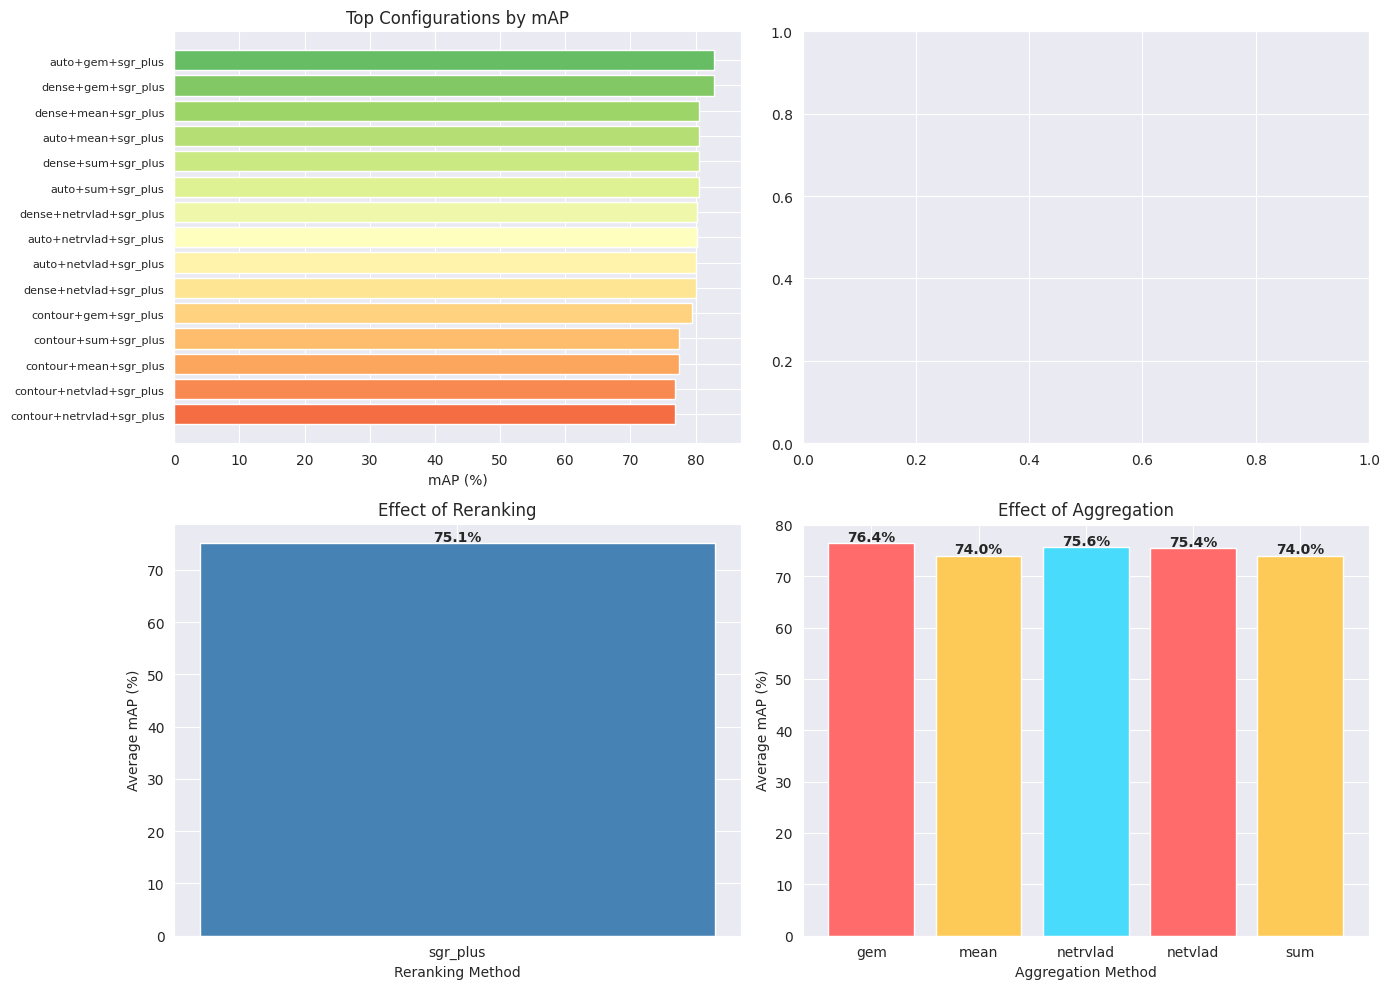

22:22:36 | INFO     | ℹ️  
🏆 BEST CONFIGURATION:
22:22:36 | INFO     | ℹ️     Mode: auto
22:22:36 | INFO     | ℹ️     Aggregation: gem
22:22:36 | INFO     | ℹ️     Reranking: sgr_plus
22:22:36 | INFO     | ℹ️     mAP: 82.77%


In [13]:
# ============================================================
# CELL 12: VISUALIZE ABLATION RESULTS
# ============================================================
logger.info(Colors.BOLD_CYAN + '\n' + '=' * 70 + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '📊 ABLATION RESULTS VISUALIZATION' + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)

if 'results_df' in dir() and len(results_df) > 0:
    # Display top results
    logger.info(Colors.GREEN + '\n🏆 TOP 10 CONFIGURATIONS:' + Colors.RESET)
    logger.info(Colors.CYAN + '   ╔═══════════════════════════════════════════════════════════════╗' + Colors.RESET)
    logger.info(Colors.CYAN + '   ║ Rank │ Mode     │ Agg   │ Rerank   │  mAP   │ Top-1  │ Top-5  ║' + Colors.RESET)
    logger.info(Colors.CYAN + '   ╠═══════════════════════════════════════════════════════════════╣' + Colors.RESET)
    for idx, (i, row) in enumerate(results_df.head(10).iterrows()):
        rank = idx + 1
        logger.info(Colors.CYAN + f'   ║  {rank:2d}  │ {row["mode"]:8s} │ {row["agg"]:5s} │ {row["rerank"]:8s} │ '
              f'{row["mAP"] * 100:5.2f}% │ {row["Top1"] * 100:5.2f}% │ {row["Top5"] * 100:5.2f}% ║' + Colors.RESET)
    logger.info(Colors.CYAN + '   ╚═══════════════════════════════════════════════════════════════╝' + Colors.RESET)

    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # 1. Bar plot of top configurations
    ax1 = axes[0, 0]
    top_n = min(15, len(results_df))
    top_results = results_df.head(top_n)
    labels = [f'{r["mode"]}+{r["agg"]}+{r["rerank"]}' for _, r in top_results.iterrows()]
    colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, top_n))[::-1]
    ax1.barh(range(top_n), top_results['mAP'] * 100, color=colors)
    ax1.set_yticks(range(top_n))
    ax1.set_yticklabels(labels, fontsize=8)
    ax1.set_xlabel('mAP (%)')
    ax1.set_title('Top Configurations by mAP')
    ax1.invert_yaxis()

    # 2. Heatmap by mode and aggregation
    # ax2 = axes[0, 1]
    # pivot_data = results_df[results_df['rerank'] == 'none'].pivot(
    #     index='mode', columns='agg', values='mAP'
    # ) * 100
    # sns.heatmap(pivot_data, annot=True, fmt='.1f', cmap='RdYlGn', ax=ax2,
    #             cbar_kws={'label': 'mAP (%)'})
    # ax2.set_title('mAP by Mode × Aggregation (no reranking)')

    # 3. Effect of reranking
    ax3 = axes[1, 0]
    rerank_effect = results_df.groupby('rerank')['mAP'].mean() * 100
    bars = ax3.bar(rerank_effect.index, rerank_effect.values,
                   color=['steelblue', 'coral', 'forestgreen'])
    ax3.set_xlabel('Reranking Method')
    ax3.set_ylabel('Average mAP (%)')
    ax3.set_title('Effect of Reranking')
    for bar, val in zip(bars, rerank_effect.values):
        ax3.text(bar.get_x() + bar.get_width() / 2, val + 0.5, f'{val:.1f}%',
                 ha='center', fontweight='bold')

    # 4. Effect of aggregation
    ax4 = axes[1, 1]
    agg_effect = results_df.groupby('agg')['mAP'].mean() * 100
    bars = ax4.bar(agg_effect.index, agg_effect.values,
                   color=['#ff6b6b', '#feca57', '#48dbfb'])
    ax4.set_xlabel('Aggregation Method')
    ax4.set_ylabel('Average mAP (%)')
    ax4.set_title('Effect of Aggregation')
    for bar, val in zip(bars, agg_effect.values):
        ax4.text(bar.get_x() + bar.get_width() / 2, val + 0.5, f'{val:.1f}%',
                 ha='center', fontweight='bold')

    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'ablation_visualization.png', dpi=150)
    plt.show()

    # Best configuration
    best = results_df.iloc[0]
    logger.info(Colors.GREEN + f'\n🏆 BEST CONFIGURATION:' + Colors.RESET)
    logger.info(Colors.CYAN + f'   Mode: {best["mode"]}' + Colors.RESET)
    logger.info(Colors.CYAN + f'   Aggregation: {best["agg"]}' + Colors.RESET)
    logger.info(Colors.CYAN + f'   Reranking: {best["rerank"]}' + Colors.RESET)
    logger.info(Colors.GREEN + f'   mAP: {best["mAP"] * 100:.2f}%' + Colors.RESET)
else:
    logger.error(Colors.RED + '❌ No results to display. Run ablation study first.' + Colors.RESET)

## Step 7: PCA Whitening Analysis

Test the effect of PCA whitening on retrieval performance.

In [14]:
# ============================================================
# CELL 13: PCA WHITENING ANALYSIS
# ============================================================
logger.info(Colors.BOLD_CYAN + '\n' + '=' * 70 + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '🔬 STEP 7: PCA WHITENING ANALYSIS' + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)

if best_ckpt:
    # Load model
    ckpt_data = torch.load(best_ckpt, map_location='cpu')
    emb_dim = ckpt_data.get('args', {}).get('emb_dim', 64)

    model = create_resnet_patch_encoder(emb_dim=emb_dim)
    model.load_state_dict(ckpt_data['model_state'])
    model.eval()
    model = model.to(IAM_CONFIG['device'])

    cfg = RetrievalConfig(agg_type='gem', use_power_norm=True, power_alpha=0.4)

    # Extract train descriptors for PCA fitting
    logger.info(Colors.CYAN + '\n📊 Extracting TRAIN descriptors for PCA...' + Colors.RESET)
    train_labels, train_paths, train_descs = extract_descriptors(
        model=model, csv_path=str(IAM_TRAIN_CSV), root_dir=str(ROOT),
        cfg=cfg, device=IAM_CONFIG['device'], verbose=True
    )

    # Fit PCA with different component counts
    logger.info(Colors.CYAN + '\n🔧 Fitting PCA with different dimensions...' + Colors.RESET)
    pca_results = []

    for n_components in [None, 64, 32, 16]:
        comp_label = 'Full' if n_components is None else str(n_components)

        pca = fit_pca_whitening(train_descs, n_components=n_components, whiten=True, verbose=False)

        # Extract and transform test descriptors
        test_labels, test_paths, test_descs = extract_descriptors(
            model=model, csv_path=str(IAM_TEST_CSV), root_dir=str(ROOT),
            cfg=cfg, device=IAM_CONFIG['device'], verbose=False
        )

        test_descs_pca = apply_pca_whitening(test_descs, pca, verbose=False)
        mAP, metrics = mean_average_precision(test_labels, test_descs_pca, verbose=False)

        pca_results.append({
            'n_components': comp_label,
            'mAP': mAP,
            'Top1': metrics['Top1'],
            'dim': test_descs_pca.shape[1]
        })

        logger.info(Colors.CYAN + f'   PCA-{comp_label:4s}: mAP={mAP * 100:.2f}%, dim={test_descs_pca.shape[1]}' + Colors.RESET)

    # Also test without PCA
    mAP_no_pca, metrics_no_pca = mean_average_precision(test_labels, test_descs, verbose=False)
    logger.info(Colors.CYAN + f'   No PCA:  mAP={mAP_no_pca * 100:.2f}%, dim={test_descs.shape[1]}' + Colors.RESET)

    # Visualization
    fig, ax = plt.subplots(figsize=(8, 5))
    labels_plot = ['No PCA'] + [r['n_components'] for r in pca_results]
    values = [mAP_no_pca * 100] + [r['mAP'] * 100 for r in pca_results]
    colors = ['gray'] + plt.cm.Blues(np.linspace(0.4, 0.8, len(pca_results))).tolist()

    bars = ax.bar(labels_plot, values, color=colors, edgecolor='black')
    ax.set_ylabel('mAP (%)')
    ax.set_xlabel('PCA Components')
    ax.set_title('Effect of PCA Whitening on IAM')
    ax.axhline(mAP_no_pca * 100, color='red', linestyle='--', alpha=0.5)

    for bar, val in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width() / 2, val + 0.5, f'{val:.1f}%',
                ha='center', fontweight='bold')

    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'pca_analysis.png', dpi=150)
    plt.show()

    best_pca = max(pca_results, key=lambda x: x['mAP'])
    logger.info(Colors.GREEN + f'\n🏆 Best PCA: {best_pca["n_components"]} components, mAP={best_pca["mAP"] * 100:.2f}%' + Colors.RESET)
else:
    logger.error(Colors.RED + '❌ No checkpoint available!' + Colors.RESET)

22:23:03 | INFO     | ℹ️  
22:23:03 | INFO     | ℹ️  🔬 STEP 7: PCA WHITENING ANALYSIS
22:23:03 | INFO     | ℹ️  ======================================================================


RuntimeError: Error(s) in loading state_dict for ResNetSmall:
	Missing key(s) in state_dict: "layer2.0.shortcut.0.weight", "layer2.0.shortcut.1.weight", "layer2.0.shortcut.1.bias", "layer2.0.shortcut.1.running_mean", "layer2.0.shortcut.1.running_var", "layer3.0.shortcut.0.weight", "layer3.0.shortcut.1.weight", "layer3.0.shortcut.1.bias", "layer3.0.shortcut.1.running_mean", "layer3.0.shortcut.1.running_var". 
	Unexpected key(s) in state_dict: "layer4.0.conv1.weight", "layer4.0.bn1.weight", "layer4.0.bn1.bias", "layer4.0.bn1.running_mean", "layer4.0.bn1.running_var", "layer4.0.bn1.num_batches_tracked", "layer4.0.conv2.weight", "layer4.0.bn2.weight", "layer4.0.bn2.bias", "layer4.0.bn2.running_mean", "layer4.0.bn2.running_var", "layer4.0.bn2.num_batches_tracked", "layer4.0.downsample.0.weight", "layer4.0.downsample.1.weight", "layer4.0.downsample.1.bias", "layer4.0.downsample.1.running_mean", "layer4.0.downsample.1.running_var", "layer4.0.downsample.1.num_batches_tracked", "layer4.1.conv1.weight", "layer4.1.bn1.weight", "layer4.1.bn1.bias", "layer4.1.bn1.running_mean", "layer4.1.bn1.running_var", "layer4.1.bn1.num_batches_tracked", "layer4.1.conv2.weight", "layer4.1.bn2.weight", "layer4.1.bn2.bias", "layer4.1.bn2.running_mean", "layer4.1.bn2.running_var", "layer4.1.bn2.num_batches_tracked", "layer4.2.conv1.weight", "layer4.2.bn1.weight", "layer4.2.bn1.bias", "layer4.2.bn1.running_mean", "layer4.2.bn1.running_var", "layer4.2.bn1.num_batches_tracked", "layer4.2.conv2.weight", "layer4.2.bn2.weight", "layer4.2.bn2.bias", "layer4.2.bn2.running_mean", "layer4.2.bn2.running_var", "layer4.2.bn2.num_batches_tracked", "layer2.3.conv1.weight", "layer2.3.bn1.weight", "layer2.3.bn1.bias", "layer2.3.bn1.running_mean", "layer2.3.bn1.running_var", "layer2.3.bn1.num_batches_tracked", "layer2.3.conv2.weight", "layer2.3.bn2.weight", "layer2.3.bn2.bias", "layer2.3.bn2.running_mean", "layer2.3.bn2.running_var", "layer2.3.bn2.num_batches_tracked", "layer2.0.downsample.0.weight", "layer2.0.downsample.1.weight", "layer2.0.downsample.1.bias", "layer2.0.downsample.1.running_mean", "layer2.0.downsample.1.running_var", "layer2.0.downsample.1.num_batches_tracked", "layer3.3.conv1.weight", "layer3.3.bn1.weight", "layer3.3.bn1.bias", "layer3.3.bn1.running_mean", "layer3.3.bn1.running_var", "layer3.3.bn1.num_batches_tracked", "layer3.3.conv2.weight", "layer3.3.bn2.weight", "layer3.3.bn2.bias", "layer3.3.bn2.running_mean", "layer3.3.bn2.running_var", "layer3.3.bn2.num_batches_tracked", "layer3.4.conv1.weight", "layer3.4.bn1.weight", "layer3.4.bn1.bias", "layer3.4.bn1.running_mean", "layer3.4.bn1.running_var", "layer3.4.bn1.num_batches_tracked", "layer3.4.conv2.weight", "layer3.4.bn2.weight", "layer3.4.bn2.bias", "layer3.4.bn2.running_mean", "layer3.4.bn2.running_var", "layer3.4.bn2.num_batches_tracked", "layer3.5.conv1.weight", "layer3.5.bn1.weight", "layer3.5.bn1.bias", "layer3.5.bn1.running_mean", "layer3.5.bn1.running_var", "layer3.5.bn1.num_batches_tracked", "layer3.5.conv2.weight", "layer3.5.bn2.weight", "layer3.5.bn2.bias", "layer3.5.bn2.running_mean", "layer3.5.bn2.running_var", "layer3.5.bn2.num_batches_tracked", "layer3.0.downsample.0.weight", "layer3.0.downsample.1.weight", "layer3.0.downsample.1.bias", "layer3.0.downsample.1.running_mean", "layer3.0.downsample.1.running_var", "layer3.0.downsample.1.num_batches_tracked". 
	size mismatch for conv1.weight: copying a param with shape torch.Size([64, 1, 7, 7]) from checkpoint, the shape in current model is torch.Size([32, 1, 3, 3]).
	size mismatch for bn1.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for bn1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for bn1.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for bn1.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for layer1.0.conv1.weight: copying a param with shape torch.Size([64, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 32, 3, 3]).
	size mismatch for layer1.0.bn1.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for layer1.0.bn1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for layer1.0.bn1.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for layer1.0.bn1.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for layer1.0.conv2.weight: copying a param with shape torch.Size([64, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 32, 3, 3]).
	size mismatch for layer1.0.bn2.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for layer1.0.bn2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for layer1.0.bn2.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for layer1.0.bn2.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for layer1.1.conv1.weight: copying a param with shape torch.Size([64, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 32, 3, 3]).
	size mismatch for layer1.1.bn1.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for layer1.1.bn1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for layer1.1.bn1.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for layer1.1.bn1.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for layer1.1.conv2.weight: copying a param with shape torch.Size([64, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 32, 3, 3]).
	size mismatch for layer1.1.bn2.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for layer1.1.bn2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for layer1.1.bn2.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for layer1.1.bn2.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for layer1.2.conv1.weight: copying a param with shape torch.Size([64, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 32, 3, 3]).
	size mismatch for layer1.2.bn1.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for layer1.2.bn1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for layer1.2.bn1.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for layer1.2.bn1.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for layer1.2.conv2.weight: copying a param with shape torch.Size([64, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 32, 3, 3]).
	size mismatch for layer1.2.bn2.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for layer1.2.bn2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for layer1.2.bn2.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for layer1.2.bn2.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for layer2.0.conv1.weight: copying a param with shape torch.Size([128, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 32, 3, 3]).
	size mismatch for layer2.0.bn1.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layer2.0.bn1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layer2.0.bn1.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layer2.0.bn1.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layer2.0.conv2.weight: copying a param with shape torch.Size([128, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 64, 3, 3]).
	size mismatch for layer2.0.bn2.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layer2.0.bn2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layer2.0.bn2.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layer2.0.bn2.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layer2.1.conv1.weight: copying a param with shape torch.Size([128, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 64, 3, 3]).
	size mismatch for layer2.1.bn1.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layer2.1.bn1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layer2.1.bn1.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layer2.1.bn1.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layer2.1.conv2.weight: copying a param with shape torch.Size([128, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 64, 3, 3]).
	size mismatch for layer2.1.bn2.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layer2.1.bn2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layer2.1.bn2.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layer2.1.bn2.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layer2.2.conv1.weight: copying a param with shape torch.Size([128, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 64, 3, 3]).
	size mismatch for layer2.2.bn1.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layer2.2.bn1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layer2.2.bn1.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layer2.2.bn1.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layer2.2.conv2.weight: copying a param with shape torch.Size([128, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 64, 3, 3]).
	size mismatch for layer2.2.bn2.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layer2.2.bn2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layer2.2.bn2.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layer2.2.bn2.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layer3.0.conv1.weight: copying a param with shape torch.Size([256, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 64, 3, 3]).
	size mismatch for layer3.0.bn1.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for layer3.0.bn1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for layer3.0.bn1.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for layer3.0.bn1.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for layer3.0.conv2.weight: copying a param with shape torch.Size([256, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for layer3.0.bn2.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for layer3.0.bn2.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for layer3.0.bn2.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for layer3.0.bn2.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for layer3.1.conv1.weight: copying a param with shape torch.Size([256, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for layer3.1.bn1.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for layer3.1.bn1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for layer3.1.bn1.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for layer3.1.bn1.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for layer3.1.conv2.weight: copying a param with shape torch.Size([256, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for layer3.1.bn2.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for layer3.1.bn2.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for layer3.1.bn2.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for layer3.1.bn2.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for layer3.2.conv1.weight: copying a param with shape torch.Size([256, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for layer3.2.bn1.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for layer3.2.bn1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for layer3.2.bn1.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for layer3.2.bn1.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for layer3.2.conv2.weight: copying a param with shape torch.Size([256, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for layer3.2.bn2.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for layer3.2.bn2.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for layer3.2.bn2.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for layer3.2.bn2.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for fc.weight: copying a param with shape torch.Size([128, 512]) from checkpoint, the shape in current model is torch.Size([128, 128]).

## Step 8: SGR Reranking Parameter Tuning

Find optimal SGR parameters (k, gamma, iterations).

In [ ]:
# ============================================================
# CELL 14: SGR RERANKING PARAMETER TUNING
# ============================================================
logger.info(Colors.BOLD_CYAN + '\n' + '=' * 70 + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '🔀 STEP 8: SGR RERANKING PARAMETER TUNING' + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)

if 'test_descs_pca' in dir() or 'test_descs' in dir():
    # Use PCA-whitened descriptors if available
    base_descs = test_descs_pca if 'test_descs_pca' in dir() else test_descs

    logger.info(Colors.CYAN + f'\n📊 Base descriptors shape: {base_descs.shape}' + Colors.RESET)

    # Baseline (no reranking)
    mAP_baseline, metrics_baseline = mean_average_precision(test_labels, base_descs, verbose=False)
    logger.info(Colors.CYAN + f'   Baseline mAP: {mAP_baseline * 100:.2f}%' + Colors.RESET)

    # Test different SGR configurations
    sgr_configs = [
        (2, 0.2, 2), (2, 0.4, 2), (2, 0.6, 2),
        (3, 0.3, 2), (3, 0.4, 2), (3, 0.5, 2),
        (5, 0.3, 2), (5, 0.4, 2), (5, 0.5, 2),
        (2, 0.4, 3), (3, 0.4, 3), (5, 0.4, 3),
    ]

    logger.info(Colors.MAGENTA + f'\n🔬 Testing {len(sgr_configs)} SGR configurations...' + Colors.RESET)
    sgr_results = []

    for k, gamma, iters in tqdm(sgr_configs, desc='SGR configs'):
        descs_sgr = apply_sgr(base_descs, k=k, gamma=gamma, num_iterations=iters, verbose=False)
        mAP, metrics = mean_average_precision(test_labels, descs_sgr, verbose=False)

        sgr_results.append({
            'k': k, 'gamma': gamma, 'iterations': iters,
            'mAP': mAP, 'Top1': metrics['Top1'],
            'improvement': mAP - mAP_baseline
        })

    sgr_results = sorted(sgr_results, key=lambda x: x['mAP'], reverse=True)

    logger.info(Colors.GREEN + '\n📊 SGR RERANKING RESULTS:' + Colors.RESET)
    logger.info(Colors.CYAN + '   ╔════════════════════════════════════════════════════════════╗' + Colors.RESET)
    logger.info(Colors.CYAN + '   ║  k  │ gamma │ iter │   mAP   │  Top-1  │  Δ mAP           ║' + Colors.RESET)
    logger.info(Colors.CYAN + '   ╠════════════════════════════════════════════════════════════╣' + Colors.RESET)
    logger.info(Colors.CYAN + f'   ║  -  │   -   │   -  │ {mAP_baseline * 100:6.2f}% │ {metrics_baseline["Top1"] * 100:6.2f}% │ baseline         ║' + Colors.RESET)
    logger.info(Colors.CYAN + '   ╠════════════════════════════════════════════════════════════╣' + Colors.RESET)

    for r in sgr_results[:8]:
        delta = r['improvement'] * 100
        sign = '+' if delta >= 0 else ''
        marker = ' 🏆' if r == sgr_results[0] else ''
        logger.info(Colors.CYAN + f'   ║  {r["k"]}  │  {r["gamma"]:.1f}  │   {r["iterations"]}  │ {r["mAP"] * 100:6.2f}% │ {r["Top1"] * 100:6.2f}% │ {sign}{delta:5.2f}%{marker}         ║' + Colors.RESET)

    logger.info(Colors.CYAN + '   ╚════════════════════════════════════════════════════════════╝' + Colors.RESET)

    best_sgr = sgr_results[0]
    logger.info(Colors.GREEN + f'\n🏆 BEST SGR: k={best_sgr["k"]}, γ={best_sgr["gamma"]}, iter={best_sgr["iterations"]}' + Colors.RESET)
    logger.info(Colors.GREEN + f'   mAP: {best_sgr["mAP"] * 100:.2f}% (+{best_sgr["improvement"] * 100:.2f}%)' + Colors.RESET)
else:
    logger.error(Colors.RED + '❌ No descriptors available. Run evaluation first.' + Colors.RESET)

## Step 9: Per-Bin Analysis

Analyze performance by text quantity bins.

In [ ]:
# ============================================================
# CELL 15: PER-BIN ANALYSIS
# ============================================================
logger.info(Colors.BOLD_CYAN + '\n' + '=' * 70 + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '📊 STEP 9: PER-BIN ANALYSIS' + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)

if best_ckpt and 'descs' in dir():
    # Save descriptors
    np.save(RESULTS_DIR / 'iam_descs.npy', descs)

    # Generate labels JSON
    iam_labels = {}
    with open(IAM_TEST_CSV, 'r') as f:
        reader = csv.DictReader(f)
        for row in reader:
            iam_labels[row['image_path']] = int(row['writer_id'])

    with open(IAM_LABELS_JSON, 'w') as f:
        json.dump(iam_labels, f, indent=2)

    # Generate ranks
    logger.info(Colors.CYAN + '\n🔄 Computing ranking for all queries...' + Colors.RESET)
    make_ranks(
        descs_path=str(RESULTS_DIR / 'iam_descs.npy'),
        csv_path=str(IAM_TEST_CSV),
        out_path=str(RESULTS_DIR / 'iam_ranks.json')
    )

    # Per-bin metrics
    per_bin_args = [
        '--ranks', str(RESULTS_DIR / 'iam_ranks.json'),
        '--labels', str(IAM_LABELS_JSON),
        '--text-quantity', str(IAM_TEXT_QTY_JSON),
        '--out-csv', str(RESULTS_DIR / 'iam_per_bin_metrics.csv')
    ]
    sys.argv = ['per_bin_csv.py'] + per_bin_args

    try:
        per_bin_csv()

        # Load and analyze
        bin_df = pd.read_csv(RESULTS_DIR / 'iam_per_bin_metrics.csv')
        bin_stats = bin_df.groupby('bin')['ap_full'].agg(['mean', 'std', 'count'])

        logger.info(Colors.GREEN + '\n📊 mAP by Text Quantity Bin:' + Colors.RESET)
        logger.info(Colors.CYAN + '   ╔══════════════════════════════════════════════╗' + Colors.RESET)
        logger.info(Colors.CYAN + '   ║  Bin         │   mAP    │  Std   │  Count   ║' + Colors.RESET)
        logger.info(Colors.CYAN + '   ╠══════════════════════════════════════════════╣' + Colors.RESET)
        for bin_name, row in bin_stats.iterrows():
            logger.info(Colors.CYAN + f'   ║  {bin_name:<12} │ {row["mean"] * 100:6.2f}%  │ {row["std"] * 100:5.2f}% │  {int(row["count"]):5d}   ║' + Colors.RESET)
        logger.info(Colors.CYAN + '   ╚══════════════════════════════════════════════╝' + Colors.RESET)

        # Visualization
        fig, ax = plt.subplots(figsize=(8, 5))
        bins = bin_stats.index.tolist()
        means = bin_stats['mean'].values * 100
        stds = bin_stats['std'].values * 100

        bars = ax.bar(range(len(bins)), means, yerr=stds, capsize=5,
                      color=['#ff6b6b', '#feca57', '#48dbfb', '#1dd1a1'][:len(bins)],
                      edgecolor='black')
        ax.set_xticks(range(len(bins)))
        ax.set_xticklabels(bins, rotation=45, ha='right')
        ax.set_ylabel('mAP (%)')
        ax.set_title('mAP by Text Quantity Bin (IAM)')

        plt.tight_layout()
        plt.savefig(RESULTS_DIR / 'per_bin_analysis.png', dpi=150)
        plt.show()

    except Exception as e:
        logger.warning(Colors.YELLOW + f'⚠️ Per-bin analysis failed: {e}' + Colors.RESET)
else:
    logger.error(Colors.RED + '❌ Run baseline evaluation first.' + Colors.RESET)

## Step 10: Final Summary

Complete summary of all experiments and best configurations.

In [ ]:
# ============================================================
# CELL 16: FINAL SUMMARY
# ============================================================
logger.info(Colors.BOLD_CYAN + '\n' + '=' * 70 + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '🎉 IAM WRITER RETRIEVAL - FINAL SUMMARY' + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)

logger.info(Colors.CYAN + '\n📊 DATASET (Aachen/RWTH Protocol):' + Colors.RESET)
logger.info(Colors.CYAN + f'   Train: {n_train} pages from {len(train_writers)} writers' + Colors.RESET)
logger.info(Colors.CYAN + f'   Valid: {n_valid} pages from {len(valid_writers)} writers' + Colors.RESET)
logger.info(Colors.CYAN + f'   Test: {n_test} pages from {len(test_writers)} unseen writers' + Colors.RESET)
logger.info(Colors.GREEN + f'   Protocol: Writer-disjoint (correct!)' + Colors.RESET)

logger.info(Colors.CYAN + '\n⚙️  TRAINING CONFIG:' + Colors.RESET)
logger.info(Colors.CYAN + f'   Backbone: {IAM_CONFIG["backbone"]}' + Colors.RESET)
logger.info(Colors.CYAN + f'   Pretrained: {IAM_CONFIG["pretrained"]}' + Colors.RESET)
logger.info(Colors.CYAN + f'   Embedding dim: {IAM_CONFIG["emb_dim"]}' + Colors.RESET)
logger.info(Colors.CYAN + f'   Epochs: {IAM_CONFIG["epochs"]}' + Colors.RESET)
logger.info(Colors.CYAN + f'   Margin: {IAM_CONFIG["margin"]}' + Colors.RESET)

logger.info(Colors.GREEN + '\n📈 RESULTS SUMMARY:' + Colors.RESET)

# Baseline
if 'baseline_mAP' in dir():
    logger.info(Colors.CYAN + f'\n   Baseline:' + Colors.RESET)
    logger.info(Colors.CYAN + f'   └── mAP: {baseline_mAP * 100:.2f}%' + Colors.RESET)

# Best ablation
if 'results_df' in dir() and len(results_df) > 0:
    best = results_df.iloc[0]
    logger.info(Colors.CYAN + f'\n   Best Ablation ({best["mode"]}+{best["agg"]}+{best["rerank"]}):' + Colors.RESET)
    logger.info(Colors.CYAN + f'   └── mAP: {best["mAP"] * 100:.2f}%' + Colors.RESET)

# Best PCA
if 'best_pca' in dir():
    logger.info(Colors.CYAN + f'\n   Best PCA ({best_pca["n_components"]} components):' + Colors.RESET)
    logger.info(Colors.CYAN + f'   └── mAP: {best_pca["mAP"] * 100:.2f}%' + Colors.RESET)

# Best SGR
if 'best_sgr' in dir():
    logger.info(Colors.CYAN + f'\n   Best SGR (k={best_sgr["k"]}, γ={best_sgr["gamma"]}):' + Colors.RESET)
    logger.info(Colors.CYAN + f'   └── mAP: {best_sgr["mAP"] * 100:.2f}%' + Colors.RESET)

logger.info(Colors.CYAN + '\n💾 SAVED FILES:' + Colors.RESET)
logger.info(Colors.CYAN + f'   Checkpoints: {CHECKPOINT_DIR}' + Colors.RESET)
logger.info(Colors.CYAN + f'   Results: {RESULTS_DIR}' + Colors.RESET)

logger.info(Colors.GREEN + '\n' + '=' * 70 + Colors.RESET)
logger.info(Colors.GREEN + '✅ IAM Pipeline Complete!' + Colors.RESET)
logger.info(Colors.GREEN + '=' * 70 + Colors.RESET)

## 🔍 Diagnostic Analysis: Why is mAP Low & Why Does Reranking Hurt?

This section provides a comprehensive analysis of potential issues affecting performance.